In [36]:
import numpy as np
import math

from numpy import exp
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
from scipy.integrate import cumtrapz, quad
from scipy.special import erf

from WIMpy import DMUtils as DMU

from matplotlib import pyplot as plt
from matplotlib.ticker import LogLocator

import matplotlib as mpl
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=16)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

import paleopy as paleopy

import os.path

In [37]:
R_Zirc = []
E_Zirc = []
R_Obs = []
E_Obs = []
nuclei_Obs = ('Si', 'Al', 'Fe', 'Ca', 'Na', 'K', 'O')
nuclei_Zirc = ('Zr', 'Si', 'O')
fractions_Obs = [0.249, 0.054, 0.005, 0.003, 0.023, 0.035, 0.631]
fractions_Zirc = [0.1667, 0.1667, 0.6667]

rho_Obs = 2.55 #g cm^-3
rho_Zirc = 4.7

for i in range(len(nuclei_Zirc)):
    dirname = './Range/'+nuclei_Zirc[i]+'.txt'
    e, r = np.loadtxt(dirname, usecols = (0, 2), unpack = 'true')
    unit = np.loadtxt(dirname, usecols = (1), dtype = str, unpack = 'true')
    for k in range(len(unit)):
        if (unit[i] == 'GeV'): e[i] = e[i]*1000
    E_Zirc.append(e)
    R_Zirc.append(r)
    
for i in range(len(nuclei_Obs)):
    dirname = './Range/'+nuclei_Obs[i]+'.txt'
    e, r = np.loadtxt(dirname, usecols = (0, 2), unpack = 'true')
    unit = np.loadtxt(dirname, usecols = (1), dtype = str, unpack = 'true')
    for k in range(len(unit)):
        if (unit[i] == 'GeV'): e[i] = e[i]*1000
    E_Obs.append(e)
    R_Obs.append(r)
    
#R carica i range percorsi in funzione dell'energia per ogni singolo elemento

In [38]:
Rtot_Obs = np.zeros(len(R_Obs[0]))
for i in range(len(R_Obs[0])):
    for k in range(len(nuclei_Obs)):
        Rtot_Obs[i] += R_Obs[k][i]*fractions_Obs[k]
        
Rtot_Zirc = np.zeros(len(R_Zirc[0]))
for i in range(len(R_Zirc[0])):
    for k in range(len(nuclei_Zirc)):
        Rtot_Zirc[i] += R_Zirc[k][i]*fractions_Zirc[k]
        
#Così trovo i range per il composto [g/cm^2]

In [39]:
Rtot_Zirc = Rtot_Zirc/rho_Zirc
Rtot_Obs = Rtot_Obs/rho_Obs

In [40]:
import scipy as sp
import scipy.interpolate

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value='extrapolate')
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

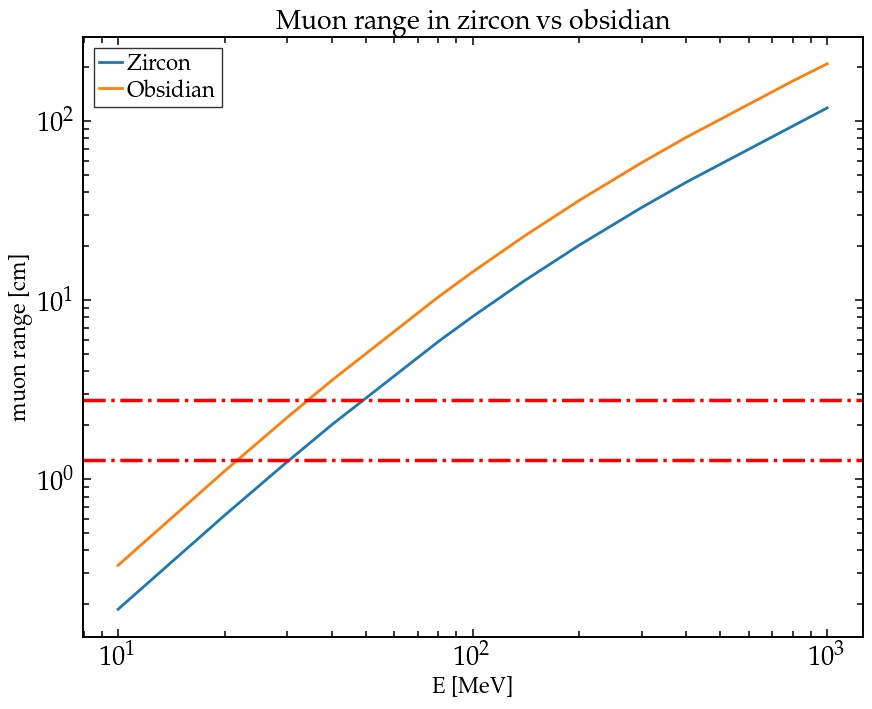

In [41]:
func_Obs = log_interp1d(E_Obs[0], Rtot_Obs)
func_Zirc = log_interp1d(E_Zirc[0], Rtot_Zirc)
En = np.linspace(10, 1000, 100)

plt.figure(figsize=(12,8))

plt.loglog(En, func_Zirc(En), label = 'Zircon', linewidth=2)
plt.loglog(En, func_Obs(En), label = 'Obsidian', linewidth=2)
plt.axhline(y = 2.77, color = 'red', linestyle ='-.')
plt.axhline(y = 1.28, color = 'red', linestyle ='-.')

plt.legend()
plt.title(r"Muon range in zircon vs obsidian")
plt.xlabel(r"E [MeV]")
plt.ylabel(r" muon range [cm]")
plt.show()

# Spontaneous fission 238U 

In [42]:
def energySFF(A0,Z0,B0,A1,Z1,B1,A2,Z2,B2):

    mp = 938.3 #MeV
    mn = 939.6 #MeV

    M  = Z0*mp + (A0-Z0)*mn - B0*A0
    m1 = Z1*mp + (A1-Z1)*mn - B1*A1
    m2 = Z2*mp + (A2-Z2)*mn - B2*A2

    Ek1 = (M**2 + m1**2 - m2**2)/(2*M) - m1
    Ek2 = (M**2 + m2**2 - m1**2)/(2*M) - m2
    
    return Ek1,Ek2

In [43]:
Z0,A0 = np.loadtxt("U238.dat", usecols = (1,2), unpack='true')

In [44]:
A_list,Z_list,B_list = np.loadtxt("U238Binding.dat", usecols = (0,1,2), unpack='true')

Z = []
A = []
E = []
Z_list0 = []
A_list0 = []

N0 = len(Z0)

for i in range (int(N0/3)):
    z1 = Z0[3*i + 1]
    a1 = A0[3*i + 1]
    z2 = Z0[3*i + 2]
    a2 = A0[3*i + 2]

    if(z1 not in Z):
        Z_list0.append(z1)
        A_list0.append(a1)
            
    if(z2 not in Z):            
        Z_list0.append(z2)
        A_list0.append(a2)
            
    Z.append(Z0[3*i + 1])
    A.append(A0[3*i + 1])
        
    Z.append(Z0[3*i + 2])
    A.append(A0[3*i + 2])
    
    b1 = 0
    b2 = 0
    
    for j in range(len(Z_list)):
        if(z1 == Z_list[j] and a1 == A_list[j]):
            b1 = B_list[j]            
        if(z2 == Z_list[j] and a2 == A_list[j]):
            b2 = B_list[j]
            
    e1,e2 = energySFF(238,92,7.570126,a1,z1,b1,a2,z2,b2)
    print(e1,e2)
    E.append(e1) # MeV
    E.append(e2)

#print(Z_list0)
#print(A_list0)
        
N = len(Z)
M = len(Z_list)

#Z[] contains all the possible Z which comes from 238U fission organized as: Z1,Z2,Z1,Z2...(Z1<Z2). A contains their
#A, E[] contains their kinetik energy

103.33302430569893 68.68065569430473
98.30535772773146 73.7695534722734
94.72757499855652 76.11306900145428
104.9357467051741 64.98117529487354
94.72757499855652 76.11306900145428
101.53233076952165 74.88910723049776
106.84985364864406 73.53182835137704
98.30535772773146 73.7695534722734
103.33302430569893 68.68065569430473
98.30535772773146 73.7695534722734
98.74287090543658 66.78900109455572
111.58401913531998 66.68379286467098
105.43026502800058 67.64079697200214
105.43026502800058 67.64079697200214
98.30535772773146 73.7695534722734
95.28515989694279 72.74161710309272
96.73899387537676 76.4132021246478
94.72757499855652 76.11306900145428
94.84950378986832 54.68027821017313
100.85577821952756 78.31389978049265
100.85577821952756 78.31389978049265
98.30535772773146 73.7695534722734
95.28515989694279 72.74161710309272
106.84985364864406 73.53182835137704
97.22560050344327 79.4514494965697
105.12027317428146 73.60607882573095
94.72757499855652 76.11306900145428
102.72981338776299 67.08

100.00305892665347 60.83887307337136
96.73899387537676 76.4132021246478
96.73899387537676 76.4132021246478
105.43026502800058 67.64079697200214
94.72757499855652 76.11306900145428
95.28515989694279 72.74161710309272
104.60223213923746 74.52773986077227
95.28515989694279 72.74161710309272
105.43026502800058 67.64079697200214
100.00305892665347 60.83887307337136
104.60223213923746 74.52773986077227
95.28515989694279 72.74161710309272
98.30535772773146 73.7695534722734
106.84985364864406 73.53182835137704
102.29907366418047 74.16125833583646
96.73899387537676 76.4132021246478
100.85577821952756 78.31389978049265
97.22560050344327 79.4514494965697
101.53233076952165 74.88910723049776
101.53233076952165 74.88910723049776
96.01123862290115 82.54928537708474
104.9357467051741 64.98117529487354
102.72981338776299 67.08411861225613
104.60223213923746 74.52773986077227
97.22560050344327 79.4514494965697
104.9357467051741 64.98117529487354
109.41587206954136 68.96831993045635
103.33302430569893 6

103.33302430569893 68.68065569430473
106.84985364864406 73.53182835137704
101.53233076952165 74.88910723049776
89.91556266526459 79.9712733347842
100.85577821952756 78.31389978049265
104.60223213923746 74.52773986077227
105.12027317428146 73.60607882573095
100.85577821952756 78.31389978049265
91.17239962879103 77.08145137123938
96.73899387537676 76.4132021246478
102.72981338776299 67.08411861225613
104.9357467051741 64.98117529487354
105.12027317428146 73.60607882573095
102.72981338776299 67.08411861225613
111.58401913531998 66.68379286467098
106.84985364864406 73.53182835137704
102.29907366418047 74.16125833583646
96.73899387537676 76.4132021246478
91.17239962879103 77.08145137123938
109.41587206954136 68.96831993045635
109.41587206954136 68.96831993045635
102.29907366418047 74.16125833583646
96.73899387537676 76.4132021246478
105.43026502800058 67.64079697200214
103.33302430569893 68.68065569430473
91.17239962879103 77.08145137123938
96.73899387537676 76.4132021246478
96.738993875376

98.74287090543658 66.78900109455572
98.74287090543658 66.78900109455572
98.74287090543658 66.78900109455572
102.29907366418047 74.16125833583646
106.84985364864406 73.53182835137704
95.28515989694279 72.74161710309272
103.29960751597537 56.36728448403301
100.85577821952756 78.31389978049265
98.74287090543658 66.78900109455572
94.72757499855652 76.11306900145428
105.12027317428146 73.60607882573095
105.43026502800058 67.64079697200214
101.53233076952165 74.88910723049776
102.29907366418047 74.16125833583646
101.36335146513011 56.33861053487635
96.73899387537676 76.4132021246478
98.74287090543658 66.78900109455572
103.33302430569893 68.68065569430473
106.84985364864406 73.53182835137704
101.53233076952165 74.88910723049776
98.74287090543658 66.78900109455572
102.72981338776299 67.08411861225613
102.72981338776299 67.08411861225613
109.41587206954136 68.96831993045635
104.60223213923746 74.52773986077227
96.73899387537676 76.4132021246478
98.74287090543658 66.78900109455572
95.28515989694

98.30535772773146 73.7695534722734
106.84985364864406 73.53182835137704
98.74287090543658 66.78900109455572
102.29907366418047 74.16125833583646
106.84985364864406 73.53182835137704
111.58401913531998 66.68379286467098
95.28515989694279 72.74161710309272
97.22560050344327 79.4514494965697
94.72757499855652 76.11306900145428
106.84985364864406 73.53182835137704
102.72981338776299 67.08411861225613
104.9357467051741 64.98117529487354
104.60223213923746 74.52773986077227
104.9357467051741 64.98117529487354
105.43026502800058 67.64079697200214
102.29907366418047 74.16125833583646
101.53233076952165 74.88910723049776
103.33302430569893 68.68065569430473
100.00305892665347 60.83887307337136
102.29907366418047 74.16125833583646
104.60223213923746 74.52773986077227
100.85577821952756 78.31389978049265
104.60223213923746 74.52773986077227
102.29907366418047 74.16125833583646
100.00305892665347 60.83887307337136
104.9357467051741 64.98117529487354
102.72981338776299 67.08411861225613
102.7298133

105.12027317428146 73.60607882573095
95.28515989694279 72.74161710309272
104.60223213923746 74.52773986077227
98.30535772773146 73.7695534722734
102.29907366418047 74.16125833583646
97.22560050344327 79.4514494965697
104.60223213923746 74.52773986077227
96.73899387537676 76.4132021246478
106.84985364864406 73.53182835137704
103.33302430569893 68.68065569430473
104.60223213923746 74.52773986077227
101.14724839080009 59.36761360921082
106.84985364864406 73.53182835137704
105.12027317428146 73.60607882573095
97.22560050344327 79.4514494965697
98.30535772773146 73.7695534722734
105.12027317428146 73.60607882573095
105.12027317428146 73.60607882573095
101.53233076952165 74.88910723049776
109.41587206954136 68.96831993045635
100.85577821952756 78.31389978049265
102.29907366418047 74.16125833583646
91.17239962879103 77.08145137123938
104.60223213923746 74.52773986077227
100.00305892665347 60.83887307337136
95.28515989694279 72.74161710309272
98.74287090543658 66.78900109455572
104.60223213923

95.28515989694279 72.74161710309272
102.72981338776299 67.08411861225613
105.12027317428146 73.60607882573095
95.28515989694279 72.74161710309272
109.41587206954136 68.96831993045635
98.74287090543658 66.78900109455572
102.72981338776299 67.08411861225613
109.41587206954136 68.96831993045635
97.22560050344327 79.4514494965697
98.74287090543658 66.78900109455572
96.73899387537676 76.4132021246478
102.72981338776299 67.08411861225613
94.72757499855652 76.11306900145428
105.12027317428146 73.60607882573095
100.00305892665347 60.83887307337136
97.22560050344327 79.4514494965697
104.60223213923746 74.52773986077227
105.43026502800058 67.64079697200214
105.12027317428146 73.60607882573095
98.30535772773146 73.7695534722734
100.85577821952756 78.31389978049265
101.53233076952165 74.88910723049776
100.00305892665347 60.83887307337136
96.73899387537676 76.4132021246478
98.30535772773146 73.7695534722734
105.43026502800058 67.64079697200214
105.12027317428146 73.60607882573095
98.74287090543658 

101.53233076952165 74.88910723049776
109.41587206954136 68.96831993045635
96.73899387537676 76.4132021246478
98.30535772773146 73.7695534722734
104.60223213923746 74.52773986077227
105.12027317428146 73.60607882573095
104.60223213923746 74.52773986077227
95.28515989694279 72.74161710309272
101.53233076952165 74.88910723049776
96.73899387537676 76.4132021246478
100.1516371856851 53.656404814333655
96.73899387537676 76.4132021246478
98.74287090543658 66.78900109455572
101.36335146513011 56.33861053487635
96.73899387537676 76.4132021246478
106.84985364864406 73.53182835137704
101.36335146513011 56.33861053487635
93.37310626011458 77.61203573990497
104.9357467051741 64.98117529487354
100.85577821952756 78.31389978049265
97.22560050344327 79.4514494965697
94.72757499855652 76.11306900145428
98.30535772773146 73.7695534722734
104.60223213923746 74.52773986077227
96.73899387537676 76.4132021246478
98.74287090543658 66.78900109455572
96.73899387537676 76.4132021246478
105.43026502800058 67.640

95.28515989694279 72.74161710309272
104.60223213923746 74.52773986077227
105.12027317428146 73.60607882573095
94.84950378986832 54.68027821017313
95.28515989694279 72.74161710309272
101.53233076952165 74.88910723049776
94.72757499855652 76.11306900145428
100.85577821952756 78.31389978049265
109.41587206954136 68.96831993045635
103.33302430569893 68.68065569430473
105.43026502800058 67.64079697200214
105.43026502800058 67.64079697200214
104.60223213923746 74.52773986077227
104.9357467051741 64.98117529487354
97.22560050344327 79.4514494965697
104.60223213923746 74.52773986077227
105.43026502800058 67.64079697200214
93.37310626011458 77.61203573990497
104.60223213923746 74.52773986077227
100.85577821952756 78.31389978049265
105.12027317428146 73.60607882573095
93.37310626011458 77.61203573990497
104.60223213923746 74.52773986077227
105.43026502800058 67.64079697200214
98.30535772773146 73.7695534722734
95.28515989694279 72.74161710309272
105.43026502800058 67.64079697200214
104.602232139

104.9357467051741 64.98117529487354
96.73899387537676 76.4132021246478
98.74287090543658 66.78900109455572
106.84985364864406 73.53182835137704
103.33302430569893 68.68065569430473
94.72757499855652 76.11306900145428
98.30535772773146 73.7695534722734
97.27061300554487 55.063158994482365
102.29907366418047 74.16125833583646
101.53233076952165 74.88910723049776
93.37310626011458 77.61203573990497
106.84985364864406 73.53182835137704
102.29907366418047 74.16125833583646
106.84985364864406 73.53182835137704
100.85577821952756 78.31389978049265
100.00305892665347 60.83887307337136
96.73899387537676 76.4132021246478
105.12027317428146 73.60607882573095
98.30535772773146 73.7695534722734
105.12027317428146 73.60607882573095
94.72757499855652 76.11306900145428
104.9357467051741 64.98117529487354
105.12027317428146 73.60607882573095
102.29907366418047 74.16125833583646
102.72981338776299 67.08411861225613
95.28515989694279 72.74161710309272
95.28515989694279 72.74161710309272
102.7298133877629

97.22560050344327 79.4514494965697
94.84950378986832 54.68027821017313
105.43026502800058 67.64079697200214
98.30535772773146 73.7695534722734
106.84985364864406 73.53182835137704
102.72981338776299 67.08411861225613
101.53233076952165 74.88910723049776
96.73899387537676 76.4132021246478
103.33302430569893 68.68065569430473
101.36335146513011 56.33861053487635
102.72981338776299 67.08411861225613
97.22560050344327 79.4514494965697
98.30535772773146 73.7695534722734
100.85577821952756 78.31389978049265
109.41587206954136 68.96831993045635
94.72757499855652 76.11306900145428
101.53233076952165 74.88910723049776
104.60223213923746 74.52773986077227
102.72981338776299 67.08411861225613
101.36335146513011 56.33861053487635
105.12027317428146 73.60607882573095
95.28515989694279 72.74161710309272
93.37310626011458 77.61203573990497
102.29907366418047 74.16125833583646
98.74287090543658 66.78900109455572
91.17239962879103 77.08145137123938
109.41587206954136 68.96831993045635
106.8498536486440

105.12027317428146 73.60607882573095
104.9357467051741 64.98117529487354
98.30535772773146 73.7695534722734
104.60223213923746 74.52773986077227
103.33302430569893 68.68065569430473
94.72757499855652 76.11306900145428
106.84985364864406 73.53182835137704
98.74287090543658 66.78900109455572
106.84985364864406 73.53182835137704
109.41587206954136 68.96831993045635
104.9357467051741 64.98117529487354
104.60223213923746 74.52773986077227
100.00305892665347 60.83887307337136
104.9357467051741 64.98117529487354
98.30535772773146 73.7695534722734
102.29907366418047 74.16125833583646
104.60223213923746 74.52773986077227
106.84985364864406 73.53182835137704
98.74287090543658 66.78900109455572
103.33302430569893 68.68065569430473
106.84985364864406 73.53182835137704
102.29907366418047 74.16125833583646
103.33302430569893 68.68065569430473
98.74287090543658 66.78900109455572
97.22560050344327 79.4514494965697
98.30535772773146 73.7695534722734
103.33302430569893 68.68065569430473
102.299073664180

96.73899387537676 76.4132021246478
111.58401913531998 66.68379286467098
94.84950378986832 54.68027821017313
102.72981338776299 67.08411861225613
104.9357467051741 64.98117529487354
105.12027317428146 73.60607882573095
102.72981338776299 67.08411861225613
93.37310626011458 77.61203573990497
93.37310626011458 77.61203573990497
101.53233076952165 74.88910723049776
102.72981338776299 67.08411861225613
93.37310626011458 77.61203573990497
96.73899387537676 76.4132021246478
95.28515989694279 72.74161710309272
104.60223213923746 74.52773986077227
97.22560050344327 79.4514494965697
104.60223213923746 74.52773986077227
105.12027317428146 73.60607882573095
109.41587206954136 68.96831993045635
101.36335146513011 56.33861053487635
105.12027317428146 73.60607882573095
109.41587206954136 68.96831993045635
111.58401913531998 66.68379286467098
96.73899387537676 76.4132021246478
98.74287090543658 66.78900109455572
106.84985364864406 73.53182835137704
102.29907366418047 74.16125833583646
102.299073664180

101.53233076952165 74.88910723049776
97.22560050344327 79.4514494965697
97.22560050344327 79.4514494965697
96.73899387537676 76.4132021246478
105.12027317428146 73.60607882573095
101.53233076952165 74.88910723049776
98.30535772773146 73.7695534722734
106.84985364864406 73.53182835137704
97.27061300554487 55.063158994482365
101.14724839080009 59.36761360921082
104.9357467051741 64.98117529487354
104.60223213923746 74.52773986077227
104.60223213923746 74.52773986077227
103.33302430569893 68.68065569430473
102.72981338776299 67.08411861225613
101.53233076952165 74.88910723049776
102.29907366418047 74.16125833583646
106.84985364864406 73.53182835137704
104.60223213923746 74.52773986077227
98.74287090543658 66.78900109455572
89.91556266526459 79.9712733347842
106.84985364864406 73.53182835137704
91.17239962879103 77.08145137123938
104.60223213923746 74.52773986077227
109.41587206954136 68.96831993045635
93.37310626011458 77.61203573990497
96.73899387537676 76.4132021246478
91.79308137264161

95.28515989694279 72.74161710309272
102.72981338776299 67.08411861225613
105.43026502800058 67.64079697200214
95.28515989694279 72.74161710309272
97.22560050344327 79.4514494965697
103.29960751597537 56.36728448403301
91.79308137264161 80.27077362735872
101.53233076952165 74.88910723049776
95.28515989694279 72.74161710309272
100.85577821952756 78.31389978049265
103.29960751597537 56.36728448403301
100.85577821952756 78.31389978049265
101.53233076952165 74.88910723049776
101.53233076952165 74.88910723049776
96.73899387537676 76.4132021246478
100.00305892665347 60.83887307337136
97.22560050344327 79.4514494965697
100.85577821952756 78.31389978049265
97.22560050344327 79.4514494965697
102.29907366418047 74.16125833583646
93.37310626011458 77.61203573990497
101.53233076952165 74.88910723049776
103.33302430569893 68.68065569430473
95.28515989694279 72.74161710309272
105.12027317428146 73.60607882573095
101.53233076952165 74.88910723049776
102.29907366418047 74.16125833583646
98.742870905436

101.36335146513011 56.33861053487635
102.29907366418047 74.16125833583646
105.12027317428146 73.60607882573095
95.28515989694279 72.74161710309272
102.29907366418047 74.16125833583646
103.33302430569893 68.68065569430473
91.17239962879103 77.08145137123938
96.73899387537676 76.4132021246478
102.72981338776299 67.08411861225613
100.00305892665347 60.83887307337136
105.43026502800058 67.64079697200214
97.22560050344327 79.4514494965697
97.22560050344327 79.4514494965697
104.9357467051741 64.98117529487354
105.43026502800058 67.64079697200214
96.73899387537676 76.4132021246478
103.33302430569893 68.68065569430473
98.74287090543658 66.78900109455572
98.74287090543658 66.78900109455572
106.84985364864406 73.53182835137704
106.84985364864406 73.53182835137704
97.27061300554487 55.063158994482365
95.28515989694279 72.74161710309272
104.60223213923746 74.52773986077227
98.74287090543658 66.78900109455572
102.29907366418047 74.16125833583646
105.43026502800058 67.64079697200214
91.1723996287910

105.43026502800058 67.64079697200214
95.28515989694279 72.74161710309272
98.74287090543658 66.78900109455572
101.36335146513011 56.33861053487635
88.51326312302263 81.41759687698504
101.53233076952165 74.88910723049776
109.41587206954136 68.96831993045635
104.9357467051741 64.98117529487354
106.84985364864406 73.53182835137704
95.28515989694279 72.74161710309272
104.60223213923746 74.52773986077227
97.22560050344327 79.4514494965697
106.84985364864406 73.53182835137704
100.00305892665347 60.83887307337136
96.73899387537676 76.4132021246478
105.12027317428146 73.60607882573095
104.9357467051741 64.98117529487354
97.22560050344327 79.4514494965697
96.73899387537676 76.4132021246478
105.43026502800058 67.64079697200214
97.27061300554487 55.063158994482365
91.17239962879103 77.08145137123938
105.43026502800058 67.64079697200214
101.53233076952165 74.88910723049776
104.60223213923746 74.52773986077227
94.72757499855652 76.11306900145428
89.91556266526459 79.9712733347842
101.53233076952165 

98.30535772773146 73.7695534722734
100.00305892665347 60.83887307337136
104.60223213923746 74.52773986077227
106.84985364864406 73.53182835137704
94.72757499855652 76.11306900145428
104.60223213923746 74.52773986077227
105.12027317428146 73.60607882573095
104.9357467051741 64.98117529487354
93.37310626011458 77.61203573990497
93.37310626011458 77.61203573990497
98.74287090543658 66.78900109455572
105.12027317428146 73.60607882573095
101.53233076952165 74.88910723049776
106.84985364864406 73.53182835137704
95.28515989694279 72.74161710309272
97.22560050344327 79.4514494965697
94.72757499855652 76.11306900145428
101.53233076952165 74.88910723049776
98.74287090543658 66.78900109455572
95.28515989694279 72.74161710309272
98.30535772773146 73.7695534722734
95.28515989694279 72.74161710309272
103.33302430569893 68.68065569430473
104.60223213923746 74.52773986077227
96.73899387537676 76.4132021246478
105.43026502800058 67.64079697200214
102.72981338776299 67.08411861225613
100.85577821952756 

103.33302430569893 68.68065569430473
97.22560050344327 79.4514494965697
104.60223213923746 74.52773986077227
98.74287090543658 66.78900109455572
101.53233076952165 74.88910723049776
95.28515989694279 72.74161710309272
105.43026502800058 67.64079697200214
103.33302430569893 68.68065569430473
98.74287090543658 66.78900109455572
106.84985364864406 73.53182835137704
97.22560050344327 79.4514494965697
102.29907366418047 74.16125833583646
98.30535772773146 73.7695534722734
101.53233076952165 74.88910723049776
98.30535772773146 73.7695534722734
98.74287090543658 66.78900109455572
104.9357467051741 64.98117529487354
96.73899387537676 76.4132021246478
100.85577821952756 78.31389978049265
101.53233076952165 74.88910723049776
98.74287090543658 66.78900109455572
105.12027317428146 73.60607882573095
106.84985364864406 73.53182835137704
106.84985364864406 73.53182835137704
95.28515989694279 72.74161710309272
97.27061300554487 55.063158994482365
98.30535772773146 73.7695534722734
105.12027317428146 7

109.41587206954136 68.96831993045635
100.00305892665347 60.83887307337136
100.00305892665347 60.83887307337136
93.37310626011458 77.61203573990497
100.85577821952756 78.31389978049265
98.74287090543658 66.78900109455572
95.28515989694279 72.74161710309272
109.41587206954136 68.96831993045635
106.84985364864406 73.53182835137704
104.9357467051741 64.98117529487354
104.9357467051741 64.98117529487354
91.17239962879103 77.08145137123938
91.79308137264161 80.27077362735872
111.58401913531998 66.68379286467098
98.74287090543658 66.78900109455572
106.84985364864406 73.53182835137704
105.43026502800058 67.64079697200214
96.73899387537676 76.4132021246478
109.41587206954136 68.96831993045635
105.12027317428146 73.60607882573095
105.43026502800058 67.64079697200214
98.74287090543658 66.78900109455572
104.60223213923746 74.52773986077227
95.28515989694279 72.74161710309272
98.30535772773146 73.7695534722734
103.33302430569893 68.68065569430473
98.30535772773146 73.7695534722734
101.5323307695216

105.43026502800058 67.64079697200214
111.58401913531998 66.68379286467098
101.14724839080009 59.36761360921082
109.41587206954136 68.96831993045635
95.28515989694279 72.74161710309272
91.79308137264161 80.27077362735872
100.85577821952756 78.31389978049265
98.74287090543658 66.78900109455572
102.72981338776299 67.08411861225613
104.60223213923746 74.52773986077227
102.29907366418047 74.16125833583646
111.58401913531998 66.68379286467098
95.28515989694279 72.74161710309272
96.73899387537676 76.4132021246478
104.60223213923746 74.52773986077227
105.43026502800058 67.64079697200214
102.72981338776299 67.08411861225613
104.60223213923746 74.52773986077227
101.53233076952165 74.88910723049776
103.33302430569893 68.68065569430473
103.33302430569893 68.68065569430473
98.74287090543658 66.78900109455572
104.60223213923746 74.52773986077227
104.9357467051741 64.98117529487354
105.12027317428146 73.60607882573095
101.14724839080009 59.36761360921082
94.72757499855652 76.11306900145428
89.9155626

98.30535772773146 73.7695534722734
104.60223213923746 74.52773986077227
101.53233076952165 74.88910723049776
109.41587206954136 68.96831993045635
95.28515989694279 72.74161710309272
95.28515989694279 72.74161710309272
101.36335146513011 56.33861053487635
105.12027317428146 73.60607882573095
95.28515989694279 72.74161710309272
94.72757499855652 76.11306900145428
101.53233076952165 74.88910723049776
103.33302430569893 68.68065569430473
102.72981338776299 67.08411861225613
105.12027317428146 73.60607882573095
96.01123862290115 82.54928537708474
105.43026502800058 67.64079697200214
98.74287090543658 66.78900109455572
102.29907366418047 74.16125833583646
96.73899387537676 76.4132021246478
100.85577821952756 78.31389978049265
104.60223213923746 74.52773986077227
100.85577821952756 78.31389978049265
93.37310626011458 77.61203573990497
95.28515989694279 72.74161710309272
98.74287090543658 66.78900109455572
102.29907366418047 74.16125833583646
103.33302430569893 68.68065569430473
104.1920127175

94.84950378986832 54.68027821017313
98.74287090543658 66.78900109455572
91.17239962879103 77.08145137123938
96.73899387537676 76.4132021246478
109.41587206954136 68.96831993045635
104.9357467051741 64.98117529487354
102.72981338776299 67.08411861225613
102.29907366418047 74.16125833583646
109.41587206954136 68.96831993045635
97.22560050344327 79.4514494965697
104.60223213923746 74.52773986077227
95.28515989694279 72.74161710309272
105.43026502800058 67.64079697200214
100.00305892665347 60.83887307337136
96.73899387537676 76.4132021246478
101.14724839080009 59.36761360921082
102.29907366418047 74.16125833583646
103.33302430569893 68.68065569430473
106.84985364864406 73.53182835137704
102.29907366418047 74.16125833583646
102.72981338776299 67.08411861225613
106.84985364864406 73.53182835137704
98.74287090543658 66.78900109455572
100.85577821952756 78.31389978049265
91.79308137264161 80.27077362735872
100.00305892665347 60.83887307337136
97.22560050344327 79.4514494965697
109.415872069541

96.01123862290115 82.54928537708474
94.72757499855652 76.11306900145428
104.60223213923746 74.52773986077227
111.58401913531998 66.68379286467098
106.84985364864406 73.53182835137704
96.73899387537676 76.4132021246478
104.60223213923746 74.52773986077227
104.60223213923746 74.52773986077227
103.33302430569893 68.68065569430473
95.28515989694279 72.74161710309272
105.12027317428146 73.60607882573095
101.36335146513011 56.33861053487635
102.29907366418047 74.16125833583646
101.53233076952165 74.88910723049776
100.00305892665347 60.83887307337136
100.85577821952756 78.31389978049265
97.22560050344327 79.4514494965697
104.60223213923746 74.52773986077227
109.41587206954136 68.96831993045635
97.22560050344327 79.4514494965697
105.12027317428146 73.60607882573095
98.74287090543658 66.78900109455572
96.73899387537676 76.4132021246478
98.74287090543658 66.78900109455572
101.53233076952165 74.88910723049776
103.33302430569893 68.68065569430473
102.29907366418047 74.16125833583646
94.72757499855

95.28515989694279 72.74161710309272
94.72757499855652 76.11306900145428
101.53233076952165 74.88910723049776
95.28515989694279 72.74161710309272
98.74287090543658 66.78900109455572
105.43026502800058 67.64079697200214
95.28515989694279 72.74161710309272
98.30535772773146 73.7695534722734
104.9357467051741 64.98117529487354
101.53233076952165 74.88910723049776
98.30535772773146 73.7695534722734
100.85577821952756 78.31389978049265
96.73899387537676 76.4132021246478
98.74287090543658 66.78900109455572
109.41587206954136 68.96831993045635
109.41587206954136 68.96831993045635
101.14724839080009 59.36761360921082
106.84985364864406 73.53182835137704
102.72981338776299 67.08411861225613
100.00305892665347 60.83887307337136
102.72981338776299 67.08411861225613
102.29907366418047 74.16125833583646
96.73899387537676 76.4132021246478
91.17239962879103 77.08145137123938
96.73899387537676 76.4132021246478
109.41587206954136 68.96831993045635
102.29907366418047 74.16125833583646
104.60223213923746 

105.12027317428146 73.60607882573095
101.53233076952165 74.88910723049776
101.53233076952165 74.88910723049776
106.84985364864406 73.53182835137704
105.12027317428146 73.60607882573095
100.85577821952756 78.31389978049265
102.72981338776299 67.08411861225613
98.74287090543658 66.78900109455572
100.85577821952756 78.31389978049265
101.53233076952165 74.88910723049776
105.12027317428146 73.60607882573095
98.30535772773146 73.7695534722734
98.30535772773146 73.7695534722734
97.22560050344327 79.4514494965697
103.33302430569893 68.68065569430473
101.14724839080009 59.36761360921082
105.43026502800058 67.64079697200214
104.60223213923746 74.52773986077227
98.30535772773146 73.7695534722734
109.41587206954136 68.96831993045635
104.9357467051741 64.98117529487354
105.12027317428146 73.60607882573095
94.72757499855652 76.11306900145428
96.73899387537676 76.4132021246478
104.9357467051741 64.98117529487354
95.28515989694279 72.74161710309272
100.85577821952756 78.31389978049265
109.415872069541

101.53233076952165 74.88910723049776
101.53233076952165 74.88910723049776
98.30535772773146 73.7695534722734
105.43026502800058 67.64079697200214
104.9357467051741 64.98117529487354
103.33302430569893 68.68065569430473
105.12027317428146 73.60607882573095
95.28515989694279 72.74161710309272
101.36335146513011 56.33861053487635
102.72981338776299 67.08411861225613
100.85577821952756 78.31389978049265
98.30535772773146 73.7695534722734
103.33302430569893 68.68065569430473
103.33302430569893 68.68065569430473
101.14724839080009 59.36761360921082
106.84985364864406 73.53182835137704
101.53233076952165 74.88910723049776
101.53233076952165 74.88910723049776
105.12027317428146 73.60607882573095
100.85577821952756 78.31389978049265
91.17239962879103 77.08145137123938
95.28515989694279 72.74161710309272
100.00305892665347 60.83887307337136
105.12027317428146 73.60607882573095
96.73899387537676 76.4132021246478
102.29907366418047 74.16125833583646
106.84985364864406 73.53182835137704
102.7298133

98.30535772773146 73.7695534722734
100.85577821952756 78.31389978049265
93.37310626011458 77.61203573990497
96.73899387537676 76.4132021246478
109.41587206954136 68.96831993045635
100.00305892665347 60.83887307337136
95.28515989694279 72.74161710309272
103.33302430569893 68.68065569430473
103.33302430569893 68.68065569430473
100.85577821952756 78.31389978049265
103.33302430569893 68.68065569430473
96.73899387537676 76.4132021246478
105.12027317428146 73.60607882573095
106.84985364864406 73.53182835137704
102.29907366418047 74.16125833583646
96.01123862290115 82.54928537708474
104.9357467051741 64.98117529487354
105.43026502800058 67.64079697200214
106.84985364864406 73.53182835137704
104.60223213923746 74.52773986077227
103.33302430569893 68.68065569430473
93.37310626011458 77.61203573990497
96.73899387537676 76.4132021246478
105.12027317428146 73.60607882573095
98.74287090543658 66.78900109455572
102.72981338776299 67.08411861225613
104.9357467051741 64.98117529487354
104.602232139237

104.19201271758357 54.79139928240329
105.43026502800058 67.64079697200214
102.29907366418047 74.16125833583646
103.33302430569893 68.68065569430473
102.29907366418047 74.16125833583646
106.84985364864406 73.53182835137704
109.41587206954136 68.96831993045635
100.85577821952756 78.31389978049265
105.43026502800058 67.64079697200214
104.9357467051741 64.98117529487354
101.53233076952165 74.88910723049776
93.37310626011458 77.61203573990497
103.33302430569893 68.68065569430473
101.53233076952165 74.88910723049776
95.28515989694279 72.74161710309272
100.00305892665347 60.83887307337136
105.43026502800058 67.64079697200214
100.00305892665347 60.83887307337136
100.85577821952756 78.31389978049265
98.74287090543658 66.78900109455572
105.12027317428146 73.60607882573095
100.85577821952756 78.31389978049265
102.72981338776299 67.08411861225613
94.72757499855652 76.11306900145428
109.41587206954136 68.96831993045635
103.33302430569893 68.68065569430473
102.72981338776299 67.08411861225613
106.84

102.72981338776299 67.08411861225613
98.30535772773146 73.7695534722734
106.84985364864406 73.53182835137704
91.17239962879103 77.08145137123938
111.58401913531998 66.68379286467098
104.60223213923746 74.52773986077227
98.30535772773146 73.7695534722734
101.14724839080009 59.36761360921082
103.33302430569893 68.68065569430473
100.85577821952756 78.31389978049265
98.74287090543658 66.78900109455572
102.29907366418047 74.16125833583646
95.28515989694279 72.74161710309272
94.72757499855652 76.11306900145428
104.60223213923746 74.52773986077227
96.73899387537676 76.4132021246478
94.84950378986832 54.68027821017313
104.9357467051741 64.98117529487354
98.30535772773146 73.7695534722734
98.30535772773146 73.7695534722734
104.9357467051741 64.98117529487354
102.72981338776299 67.08411861225613
109.41587206954136 68.96831993045635
95.28515989694279 72.74161710309272
106.84985364864406 73.53182835137704
100.00305892665347 60.83887307337136
97.22560050344327 79.4514494965697
102.72981338776299 67

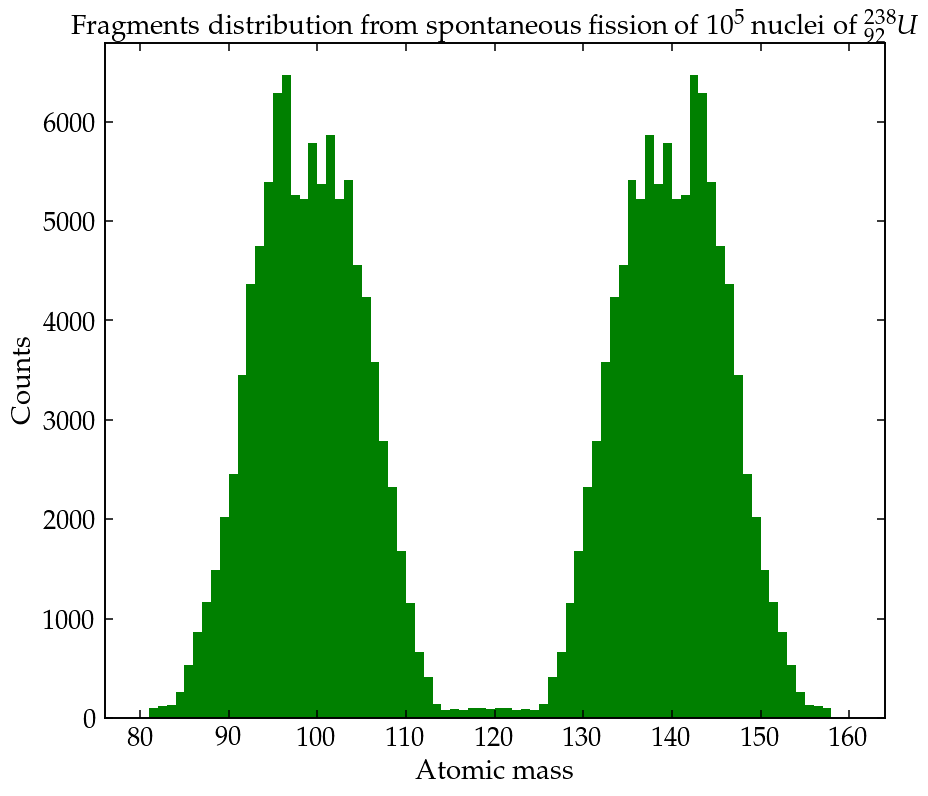

In [45]:
fig = plt.subplots(figsize =(12, 9))
plt.hist(A, 80, range = (80,160),color='g')
#plt.hist(Z, 29, range = (29,92-29),color='g')
#plt.hist(np.log10(E),80,log=True)
plt.title(r"Fragments distribution from spontaneous fission of $10^5$ nuclei of $^{238}_{92}U$", fontsize = 20)
plt.xlabel("Atomic mass", fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.savefig("FissionFrag.jpg",bbox_inches="tight")
plt.show()

In [46]:
track = []
#strag = []

#print(N)

#mineral = 'Gypsum/'
#nuclei  = ' H- O-Ca- S'

#mineral = 'Halite/'
#nuclei = 'Na-Cl.txt'

mineral = 'Obsidian/'
nuclei = 'Si-Al-Fe-Ca-Na- K- O.txt'

mineral = 'Zircon/'
nuclei = 'Zr-Si- O.txt'

#mineral = 'Cerussite/'
#nuclei = ' O-Pb- C.txt'

#mineral = 'Pyromorphite/'
#nuclei = 'Pb- P- O-Cl.txt'

appo = 0

for i in range(N):
    
    if(i%10000 == 0):
        print(i)
    
    #e takes the energy of the fragment, x and y take the range obtained in the material
    
    e,x,y  = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = (0,4,8), unpack='true')
    unit_e = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 1, dtype = str, unpack='true')
    unit_x = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 5, dtype = str, unpack='true')
    #unit_y = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 9, dtype = str, unpack='true')
    
    n = len(unit_e)
    
    for j in range(n):    
        if(unit_x[j] == "um"):
            x[j] *= 1e3
        else:
            x[j] *= 0.1
       
        '''if(unit_y[i] == "um"):
            y[i] *= 1e3
        else:
            y[i] *= 0.1'''
            
        if(unit_e[j] == "eV"):
            e[j] *= 1e-3
        elif(unit_e[j] == "MeV"):
            e[j] *= 1e3
            
    Etox = InterpolatedUnivariateSpline(e,x,k = 1)
    #Etoy = InterpolatedUnivariateSpline(e,y,k = 1)
    
    if (i % 2 == 0):   
        appo = Etox(E[i]*1e3)
        #length by the lighter fragment
    else:
        appo += Etox(E[i]*1e3)        
        track.append(appo)
        #sum of the length by the 2 objects
        
    #track.append(Etox(E[i]*1e3))
    #strag.append(Etoy(E[i]*1e3))
    
#print(min(track))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [47]:
n_bins = 100
x_min = 3 #log scale in nm
x_max = 5 #log scale in nm

#I consder the range between 1 nm and 10^5 nm

In [48]:
lenght = np.logspace(x_min,x_max,n_bins) # nm
count_U  = np.zeros(n_bins-1)

for i in range(int(N/2)):
    if(i%10000 == 0):
        print(i)
    for j in range(n_bins-1):
        if(track[i] >= lenght[j] and track[i] < lenght[j+1]):
            count_U[j] += 1
            #counting the decays which gave a track with length between length[j] and length[j+1]

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [49]:
l = np.logspace(x_min,x_max,10000)
R_U = np.zeros(10000)

for i in range(n_bins-1):
    for j in range(10000):
        if(l[j] < lenght[i+1] and l[j] >= lenght[i]):
            R_U[j] = count_U[i]

In [50]:
print(count_U)

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0. 10087. 23604. 54105. 12204.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.]


In [51]:
filename = 'U238histo.dat'

f = open(filename, "w")
print("l1  l2  N", file=f)
for j in range(len(count_U)):
    print(l[j], l[j+1], count_U[j], sep = '  ', file = f)
f.close()

# Spontaneous fission 232Th

In [52]:
Z0,A0 = np.loadtxt("Th232.dat", usecols = (1,2), unpack='true')

In [53]:
A_list,Z_list,B_list = np.loadtxt("Th232Binding.txt", usecols = (0,1,2), unpack='true')

Z = []
A = []
E = []
Z_list0 = []
A_list0 = []

N0 = len(Z0)

for i in range (int(N0/3)):
    z1 = Z0[3*i + 1]
    a1 = A0[3*i + 1]
    z2 = Z0[3*i + 2]
    a2 = A0[3*i + 2]

    if(z1 not in Z):
        Z_list0.append(z1)
        A_list0.append(a1)
            
    if(z2 not in Z):            
        Z_list0.append(z2)
        A_list0.append(a2)
            
    Z.append(Z0[3*i + 1])
    A.append(A0[3*i + 1])
        
    Z.append(Z0[3*i + 2])
    A.append(A0[3*i + 2])
    
    b1 = 0
    b2 = 0
    
    for j in range(len(Z_list)):
        if(z1 == Z_list[j] and a1 == A_list[j]):
            b1 = B_list[j] 
            #print(b1)
        if(z2 == Z_list[j] and a2 == A_list[j]):
            b2 = B_list[j]
            
    e1,e2 = energySFF(232,90,7.615034,a1,z1,b1,a2,z2,b2)
    print(e1,e2)
    E.append(e1) # MeV
    E.append(e2)

#print(Z_list0)
#print(A_list0)
        
N = len(Z)
M = len(Z_list)

#print(E)

#Z[] contains all the possible Z which comes from 238U fission organized as: Z1,Z2,Z1,Z2...(Z1<Z2). A contains their
#A, E[] contains their kinetik energy

86.83093886046845 63.54387113953999
95.46175826380204 65.0625897362479
92.47926366666798 57.59051633335184
90.81170970891253 57.5943422911223
93.76343099304358 66.22167300697765
96.59279204107588 64.65996095894661
95.46175826380204 65.0625897362479
92.57384985603858 68.94544614397455
93.76343099304358 66.22167300697765
92.47926366666798 57.59051633335184
90.58364715526113 59.56326484476449
92.57384985603858 68.94544614397455
96.44012769052642 58.965568309504306
86.83093886046845 63.54387113953999
86.02767155368929 66.36898744634527
95.46175826380204 65.0625897362479
87.83165506449586 50.8202449354867
96.59279204107588 64.65996095894661
86.02767155368929 66.36898744634527
90.81170970891253 57.5943422911223
87.83165506449586 50.8202449354867
90.58364715526113 59.56326484476449
90.53254959413607 68.62579840589024
94.12342098355293 60.779596016480355
92.28821112388687 52.410244876140496
90.53254959413607 68.62579840589024
90.69906564576377 62.93361935428402
86.02767155368929 66.36898744634

94.12342098355293 60.779596016480355
90.58364715526113 59.56326484476449
95.46175826380204 65.0625897362479
94.12342098355293 60.779596016480355
87.83165506449586 50.8202449354867
94.12342098355293 60.779596016480355
91.79312677038251 54.099165229621576
94.12342098355293 60.779596016480355
93.76343099304358 66.22167300697765
94.12342098355293 60.779596016480355
91.35100226086797 65.6761097391427
93.83449770310835 52.29677029690356
86.83093886046845 63.54387113953999
91.79312677038251 54.099165229621576
93.76343099304358 66.22167300697765
94.12342098355293 60.779596016480355
89.75582862249576 46.3724443775136
94.12342098355293 60.779596016480355
90.53254959413607 68.62579840589024
86.83093886046845 63.54387113953999
90.81170970891253 57.5943422911223
92.47926366666798 57.59051633335184
90.58364715526113 59.56326484476449
91.35100226086797 65.6761097391427
96.59279204107588 64.65996095894661
90.69906564576377 62.93361935428402
89.92229143400618 53.98667056605336
86.83093886046845 63.5438

90.53254959413607 68.62579840589024
87.83165506449586 50.8202449354867
91.79312677038251 54.099165229621576
89.92229143400618 53.98667056605336
91.79312677038251 54.099165229621576
90.69906564576377 62.93361935428402
93.76343099304358 66.22167300697765
92.76712115824921 75.40950284176506
90.53254959413607 68.62579840589024
96.44012769052642 58.965568309504306
92.57384985603858 68.94544614397455
87.83165506449586 50.8202449354867
91.35100226086797 65.6761097391427
86.02767155368929 66.36898744634527
89.92229143400618 53.98667056605336
91.35100226086797 65.6761097391427
92.76712115824921 75.40950284176506
92.47926366666798 57.59051633335184
90.81170970891253 57.5943422911223
87.88061699221726 42.84005900780903
96.59279204107588 64.65996095894661
93.76343099304358 66.22167300697765
91.35100226086797 65.6761097391427
94.12342098355293 60.779596016480355
90.81170970891253 57.5943422911223
91.57728308186051 49.15159891816438
96.44012769052642 58.965568309504306
94.12342098355293 60.779596016

91.35100226086797 65.6761097391427
94.12342098355293 60.779596016480355
93.76343099304358 66.22167300697765
87.83165506449586 50.8202449354867
90.69906564576377 62.93361935428402
86.02767155368929 66.36898744634527
87.83165506449586 50.8202449354867
93.76343099304358 66.22167300697765
91.35100226086797 65.6761097391427
96.44012769052642 58.965568309504306
86.83093886046845 63.54387113953999
96.59279204107588 64.65996095894661
90.81170970891253 57.5943422911223
95.46175826380204 65.0625897362479
93.76343099304358 66.22167300697765
90.58364715526113 59.56326484476449
89.92229143400618 53.98667056605336
86.83093886046845 63.54387113953999
93.83449770310835 52.29677029690356
91.79312677038251 54.099165229621576
90.53254959413607 68.62579840589024
96.44012769052642 58.965568309504306
93.76343099304358 66.22167300697765
92.47926366666798 57.59051633335184
91.35100226086797 65.6761097391427
87.41247836092953 46.0375136390503
91.35100226086797 65.6761097391427
92.57384985603858 68.945446143974

93.83449770310835 52.29677029690356
87.09704945331032 47.64256254670909
92.47926366666798 57.59051633335184
90.69906564576377 62.93361935428402
91.35100226086797 65.6761097391427
90.58364715526113 59.56326484476449
91.79312677038251 54.099165229621576
92.57384985603858 68.94544614397455
91.79312677038251 54.099165229621576
90.58364715526113 59.56326484476449
91.35100226086797 65.6761097391427
89.42729038126708 70.20335161876574
87.83165506449586 50.8202449354867
91.35100226086797 65.6761097391427
92.47926366666798 57.59051633335184
87.83165506449586 50.8202449354867
93.76343099304358 66.22167300697765
89.92229143400618 53.98667056605336
90.81170970891253 57.5943422911223
91.79312677038251 54.099165229621576
95.46175826380204 65.0625897362479
95.46175826380204 65.0625897362479
86.83093886046845 63.54387113953999
90.58364715526113 59.56326484476449
96.59279204107588 64.65996095894661
90.69906564576377 62.93361935428402
95.46175826380204 65.0625897362479
86.83093886046845 63.5438711395399

91.79312677038251 54.099165229621576
94.12342098355293 60.779596016480355
95.46175826380204 65.0625897362479
91.35100226086797 65.6761097391427
92.47926366666798 57.59051633335184
96.44012769052642 58.965568309504306
94.12342098355293 60.779596016480355
86.83093886046845 63.54387113953999
90.58364715526113 59.56326484476449
93.83449770310835 52.29677029690356
87.09704945331032 47.64256254670909
87.83165506449586 50.8202449354867
91.57728308186051 49.15159891816438
91.35100226086797 65.6761097391427
93.76343099304358 66.22167300697765
94.12342098355293 60.779596016480355
90.58364715526113 59.56326484476449
90.58364715526113 59.56326484476449
86.83093886046845 63.54387113953999
86.30688153381925 42.90401046621264
96.59279204107588 64.65996095894661
87.09704945331032 47.64256254670909
90.69906564576377 62.93361935428402
95.46175826380204 65.0625897362479
92.77500676555792 43.47396123447106
87.83165506449586 50.8202449354867
96.59279204107588 64.65996095894661
96.44012769052642 58.96556830

92.76712115824921 75.40950284176506
96.44012769052642 58.965568309504306
90.58364715526113 59.56326484476449
94.12342098355293 60.779596016480355
90.69906564576377 62.93361935428402
89.92229143400618 53.98667056605336
86.02767155368929 66.36898744634527
87.88061699221726 42.84005900780903
91.79312677038251 54.099165229621576
93.76343099304358 66.22167300697765
88.62051419292402 73.30744080711156
90.81170970891253 57.5943422911223
91.79312677038251 54.099165229621576
91.79312677038251 54.099165229621576
96.59279204107588 64.65996095894661
96.59279204107588 64.65996095894661
90.58364715526113 59.56326484476449
92.28821112388687 52.410244876140496
89.42729038126708 70.20335161876574
92.47926366666798 57.59051633335184
91.79312677038251 54.099165229621576
89.42729038126708 70.20335161876574
93.76343099304358 66.22167300697765
91.35100226086797 65.6761097391427
90.58364715526113 59.56326484476449
87.3969671241648 69.82298387589981
90.53254959413607 68.62579840589024
92.57384985603858 68.945

92.47926366666798 57.59051633335184
90.53254959413607 68.62579840589024
90.69906564576377 62.93361935428402
90.81170970891253 57.5943422911223
92.57384985603858 68.94544614397455
94.12342098355293 60.779596016480355
91.35100226086797 65.6761097391427
94.12342098355293 60.779596016480355
86.83093886046845 63.54387113953999
91.79312677038251 54.099165229621576
86.83093886046845 63.54387113953999
92.57384985603858 68.94544614397455
92.57384985603858 68.94544614397455
86.83093886046845 63.54387113953999
91.79312677038251 54.099165229621576
91.35100226086797 65.6761097391427
87.41247836092953 46.0375136390503
93.76343099304358 66.22167300697765
96.44012769052642 58.965568309504306
92.47926366666798 57.59051633335184
96.59279204107588 64.65996095894661
91.79312677038251 54.099165229621576
92.57384985603858 68.94544614397455
92.57384985603858 68.94544614397455
91.57728308186051 49.15159891816438
94.12342098355293 60.779596016480355
92.47926366666798 57.59051633335184
92.57384985603858 68.9454

92.76712115824921 75.40950284176506
92.57384985603858 68.94544614397455
96.44012769052642 58.965568309504306
92.47926366666798 57.59051633335184
87.83165506449586 50.8202449354867
87.3969671241648 69.82298387589981
91.35100226086797 65.6761097391427
90.58364715526113 59.56326484476449
90.69906564576377 62.93361935428402
87.83165506449586 50.8202449354867
92.47926366666798 57.59051633335184
87.83165506449586 50.8202449354867
91.35100226086797 65.6761097391427
90.81170970891253 57.5943422911223
90.58364715526113 59.56326484476449
96.59279204107588 64.65996095894661
94.12342098355293 60.779596016480355
86.02767155368929 66.36898744634527
90.53254959413607 68.62579840589024
92.47926366666798 57.59051633335184
91.79312677038251 54.099165229621576
86.02767155368929 66.36898744634527
86.83093886046845 63.54387113953999
89.92229143400618 53.98667056605336
91.57728308186051 49.15159891816438
92.57384985603858 68.94544614397455
92.28821112388687 52.410244876140496
87.83165506449586 50.8202449354

96.44012769052642 58.965568309504306
93.83449770310835 52.29677029690356
93.76343099304358 66.22167300697765
92.47926366666798 57.59051633335184
86.83093886046845 63.54387113953999
89.42729038126708 70.20335161876574
90.81170970891253 57.5943422911223
87.09704945331032 47.64256254670909
86.02767155368929 66.36898744634527
95.46175826380204 65.0625897362479
86.02767155368929 66.36898744634527
89.92229143400618 53.98667056605336
89.92229143400618 53.98667056605336
87.83165506449586 50.8202449354867
93.83449770310835 52.29677029690356
90.69906564576377 62.93361935428402
92.57384985603858 68.94544614397455
96.44012769052642 58.965568309504306
93.83449770310835 52.29677029690356
90.58364715526113 59.56326484476449
87.83165506449586 50.8202449354867
89.92229143400618 53.98667056605336
96.59279204107588 64.65996095894661
92.47926366666798 57.59051633335184
92.57384985603858 68.94544614397455
86.02767155368929 66.36898744634527
89.42729038126708 70.20335161876574
90.69906564576377 62.933619354

86.02767155368929 66.36898744634527
96.59279204107588 64.65996095894661
89.92229143400618 53.98667056605336
92.47926366666798 57.59051633335184
93.76343099304358 66.22167300697765
89.42729038126708 70.20335161876574
86.83093886046845 63.54387113953999
93.76343099304358 66.22167300697765
88.62051419292402 73.30744080711156
93.76343099304358 66.22167300697765
86.83093886046845 63.54387113953999
93.76343099304358 66.22167300697765
95.46175826380204 65.0625897362479
90.81170970891253 57.5943422911223
87.83165506449586 50.8202449354867
91.35100226086797 65.6761097391427
92.47926366666798 57.59051633335184
95.46175826380204 65.0625897362479
92.47926366666798 57.59051633335184
92.28821112388687 52.410244876140496
92.28821112388687 52.410244876140496
86.83093886046845 63.54387113953999
90.53254959413607 68.62579840589024
95.46175826380204 65.0625897362479
92.47926366666798 57.59051633335184
96.59279204107588 64.65996095894661
86.83093886046845 63.54387113953999
92.57384985603858 68.94544614397

93.76343099304358 66.22167300697765
92.28821112388687 52.410244876140496
91.35100226086797 65.6761097391427
95.46175826380204 65.0625897362479
91.57728308186051 49.15159891816438
86.83093886046845 63.54387113953999
90.69906564576377 62.93361935428402
92.47926366666798 57.59051633335184
90.69906564576377 62.93361935428402
89.92229143400618 53.98667056605336
86.02767155368929 66.36898744634527
87.41247836092953 46.0375136390503
90.58364715526113 59.56326484476449
94.12342098355293 60.779596016480355
86.83093886046845 63.54387113953999
94.12342098355293 60.779596016480355
91.79312677038251 54.099165229621576
96.44012769052642 58.965568309504306
94.12342098355293 60.779596016480355
91.35100226086797 65.6761097391427
91.79312677038251 54.099165229621576
87.09704945331032 47.64256254670909
86.02767155368929 66.36898744634527
91.79312677038251 54.099165229621576
90.69906564576377 62.93361935428402
91.35100226086797 65.6761097391427
86.02767155368929 66.36898744634527
86.83093886046845 63.5438

95.46175826380204 65.0625897362479
96.59279204107588 64.65996095894661
93.76343099304358 66.22167300697765
86.30688153381925 42.90401046621264
89.92229143400618 53.98667056605336
91.35100226086797 65.6761097391427
93.76343099304358 66.22167300697765
89.42729038126708 70.20335161876574
92.57384985603858 68.94544614397455
92.57384985603858 68.94544614397455
86.83093886046845 63.54387113953999
95.46175826380204 65.0625897362479
90.58364715526113 59.56326484476449
92.76712115824921 75.40950284176506
87.09704945331032 47.64256254670909
90.81170970891253 57.5943422911223
92.47926366666798 57.59051633335184
91.79312677038251 54.099165229621576
90.69906564576377 62.93361935428402
90.69906564576377 62.93361935428402
96.44012769052642 58.965568309504306
96.59279204107588 64.65996095894661
92.57384985603858 68.94544614397455
93.83449770310835 52.29677029690356
93.76343099304358 66.22167300697765
92.47926366666798 57.59051633335184
92.57384985603858 68.94544614397455
86.83093886046845 63.543871139

94.12342098355293 60.779596016480355
91.79312677038251 54.099165229621576
89.42729038126708 70.20335161876574
87.3969671241648 69.82298387589981
92.57384985603858 68.94544614397455
90.58364715526113 59.56326484476449
94.12342098355293 60.779596016480355
94.77872199306148 48.03044200697332
92.47926366666798 57.59051633335184
90.69906564576377 62.93361935428402
91.79312677038251 54.099165229621576
86.83093886046845 63.54387113953999
92.47926366666798 57.59051633335184
87.83165506449586 50.8202449354867
92.47926366666798 57.59051633335184
91.35100226086797 65.6761097391427
93.76343099304358 66.22167300697765
86.02767155368929 66.36898744634527
87.83165506449586 50.8202449354867
86.83093886046845 63.54387113953999
96.44012769052642 58.965568309504306
93.76343099304358 66.22167300697765
92.57384985603858 68.94544614397455
93.76343099304358 66.22167300697765
93.83449770310835 52.29677029690356
89.92229143400618 53.98667056605336
86.83093886046845 63.54387113953999
92.57384985603858 68.945446

92.47926366666798 57.59051633335184
87.09704945331032 47.64256254670909
92.57384985603858 68.94544614397455
95.46175826380204 65.0625897362479
86.02767155368929 66.36898744634527
92.76712115824921 75.40950284176506
96.59279204107588 64.65996095894661
90.53254959413607 68.62579840589024
90.58364715526113 59.56326484476449
94.12342098355293 60.779596016480355
83.27192304538039 73.83654895465588
96.59279204107588 64.65996095894661
89.92229143400618 53.98667056605336
93.83449770310835 52.29677029690356
89.42729038126708 70.20335161876574
89.92229143400618 53.98667056605336
90.81170970891253 57.5943422911223
86.83093886046845 63.54387113953999
86.83093886046845 63.54387113953999
93.83449770310835 52.29677029690356
87.41247836092953 46.0375136390503
92.47926366666798 57.59051633335184
92.57384985603858 68.94544614397455
90.58364715526113 59.56326484476449
93.83449770310835 52.29677029690356
90.81170970891253 57.5943422911223
90.53254959413607 68.62579840589024
91.79312677038251 54.0991652296

96.59279204107588 64.65996095894661
92.57384985603858 68.94544614397455
86.02767155368929 66.36898744634527
91.79312677038251 54.099165229621576
90.58364715526113 59.56326484476449
92.47926366666798 57.59051633335184
96.59279204107588 64.65996095894661
91.35100226086797 65.6761097391427
90.58364715526113 59.56326484476449
94.12342098355293 60.779596016480355
96.59279204107588 64.65996095894661
89.92229143400618 53.98667056605336
86.83093886046845 63.54387113953999
92.47926366666798 57.59051633335184
87.3969671241648 69.82298387589981
92.47926366666798 57.59051633335184
94.12342098355293 60.779596016480355
87.83165506449586 50.8202449354867
90.69906564576377 62.93361935428402
95.46175826380204 65.0625897362479
87.83165506449586 50.8202449354867
90.53254959413607 68.62579840589024
90.81170970891253 57.5943422911223
87.3969671241648 69.82298387589981
92.28821112388687 52.410244876140496
93.76343099304358 66.22167300697765
90.58364715526113 59.56326484476449
92.57384985603858 68.9454461439

95.46175826380204 65.0625897362479
92.28821112388687 52.410244876140496
87.83165506449586 50.8202449354867
92.47926366666798 57.59051633335184
96.44012769052642 58.965568309504306
87.09704945331032 47.64256254670909
91.79312677038251 54.099165229621576
90.81170970891253 57.5943422911223
90.81170970891253 57.5943422911223
90.81170970891253 57.5943422911223
90.81170970891253 57.5943422911223
89.92229143400618 53.98667056605336
95.46175826380204 65.0625897362479
90.69906564576377 62.93361935428402
86.30688153381925 42.90401046621264
87.3969671241648 69.82298387589981
91.79312677038251 54.099165229621576
86.83093886046845 63.54387113953999
91.79312677038251 54.099165229621576
90.53254959413607 68.62579840589024
92.28821112388687 52.410244876140496
88.62051419292402 73.30744080711156
86.83093886046845 63.54387113953999
92.28821112388687 52.410244876140496
92.57384985603858 68.94544614397455
92.57384985603858 68.94544614397455
90.53254959413607 68.62579840589024
92.57384985603858 68.94544614

91.57728308186051 49.15159891816438
90.69906564576377 62.93361935428402
92.47926366666798 57.59051633335184
91.35100226086797 65.6761097391427
94.12342098355293 60.779596016480355
90.81170970891253 57.5943422911223
96.59279204107588 64.65996095894661
92.57384985603858 68.94544614397455
93.76343099304358 66.22167300697765
91.35100226086797 65.6761097391427
96.59279204107588 64.65996095894661
89.42729038126708 70.20335161876574
89.92229143400618 53.98667056605336
86.83093886046845 63.54387113953999
86.30688153381925 42.90401046621264
90.81170970891253 57.5943422911223
92.57384985603858 68.94544614397455
90.81170970891253 57.5943422911223
96.59279204107588 64.65996095894661
93.76343099304358 66.22167300697765
92.47926366666798 57.59051633335184
86.83093886046845 63.54387113953999
91.35100226086797 65.6761097391427
93.76343099304358 66.22167300697765
87.83165506449586 50.8202449354867
90.53254959413607 68.62579840589024
93.76343099304358 66.22167300697765
92.76712115824921 75.4095028417650

90.81170970891253 57.5943422911223
92.47926366666798 57.59051633335184
86.83093886046845 63.54387113953999
91.35100226086797 65.6761097391427
90.81170970891253 57.5943422911223
96.59279204107588 64.65996095894661
91.35100226086797 65.6761097391427
90.69906564576377 62.93361935428402
92.57384985603858 68.94544614397455
91.35100226086797 65.6761097391427
94.12342098355293 60.779596016480355
91.79312677038251 54.099165229621576
93.76343099304358 66.22167300697765
91.79312677038251 54.099165229621576
90.69906564576377 62.93361935428402
92.47926366666798 57.59051633335184
93.76343099304358 66.22167300697765
92.28821112388687 52.410244876140496
92.57384985603858 68.94544614397455
92.47926366666798 57.59051633335184
96.44012769052642 58.965568309504306
86.83093886046845 63.54387113953999
96.44012769052642 58.965568309504306
90.81170970891253 57.5943422911223
90.69906564576377 62.93361935428402
91.79312677038251 54.099165229621576
91.79312677038251 54.099165229621576
96.44012769052642 58.96556

87.83165506449586 50.8202449354867
93.76343099304358 66.22167300697765
92.47926366666798 57.59051633335184
90.58364715526113 59.56326484476449
89.92229143400618 53.98667056605336
91.79312677038251 54.099165229621576
91.79312677038251 54.099165229621576
96.59279204107588 64.65996095894661
87.41247836092953 46.0375136390503
96.59279204107588 64.65996095894661
95.46175826380204 65.0625897362479
92.47926366666798 57.59051633335184
95.46175826380204 65.0625897362479
90.53254959413607 68.62579840589024
96.59279204107588 64.65996095894661
87.83165506449586 50.8202449354867
93.76343099304358 66.22167300697765
90.53254959413607 68.62579840589024
89.92229143400618 53.98667056605336
87.83165506449586 50.8202449354867
87.88061699221726 42.84005900780903
91.35100226086797 65.6761097391427
94.12342098355293 60.779596016480355
92.47926366666798 57.59051633335184
91.35100226086797 65.6761097391427
92.47926366666798 57.59051633335184
93.76343099304358 66.22167300697765
93.76343099304358 66.221673006977

96.59279204107588 64.65996095894661
91.35100226086797 65.6761097391427
86.83093886046845 63.54387113953999
93.76343099304358 66.22167300697765
91.57728308186051 49.15159891816438
92.47926366666798 57.59051633335184
91.35100226086797 65.6761097391427
90.69906564576377 62.93361935428402
93.76343099304358 66.22167300697765
92.76712115824921 75.40950284176506
91.57728308186051 49.15159891816438
92.28821112388687 52.410244876140496
89.92229143400618 53.98667056605336
92.47926366666798 57.59051633335184
91.79312677038251 54.099165229621576
90.58364715526113 59.56326484476449
92.47926366666798 57.59051633335184
86.83093886046845 63.54387113953999
87.09704945331032 47.64256254670909
90.81170970891253 57.5943422911223
96.44012769052642 58.965568309504306
91.79312677038251 54.099165229621576
92.57384985603858 68.94544614397455
91.35100226086797 65.6761097391427
90.69906564576377 62.93361935428402
87.09704945331032 47.64256254670909
87.3969671241648 69.82298387589981
90.53254959413607 68.62579840

91.35100226086797 65.6761097391427
93.83449770310835 52.29677029690356
89.92229143400618 53.98667056605336
94.12342098355293 60.779596016480355
90.69906564576377 62.93361935428402
96.59279204107588 64.65996095894661
87.83165506449586 50.8202449354867
90.58364715526113 59.56326484476449
92.57384985603858 68.94544614397455
92.57384985603858 68.94544614397455
92.47926366666798 57.59051633335184
91.79312677038251 54.099165229621576
90.58364715526113 59.56326484476449
90.69906564576377 62.93361935428402
87.3969671241648 69.82298387589981
92.47926366666798 57.59051633335184
90.69906564576377 62.93361935428402
91.79312677038251 54.099165229621576
87.83165506449586 50.8202449354867
93.76343099304358 66.22167300697765
90.58364715526113 59.56326484476449
92.28821112388687 52.410244876140496
93.83449770310835 52.29677029690356
90.69906564576377 62.93361935428402
90.53254959413607 68.62579840589024
89.92229143400618 53.98667056605336
89.42729038126708 70.20335161876574
93.76343099304358 66.2216730

90.58364715526113 59.56326484476449
92.57384985603858 68.94544614397455
87.3969671241648 69.82298387589981
94.12342098355293 60.779596016480355
93.83449770310835 52.29677029690356
92.47926366666798 57.59051633335184
90.81170970891253 57.5943422911223
91.35100226086797 65.6761097391427
90.69906564576377 62.93361935428402
93.76343099304358 66.22167300697765
93.76343099304358 66.22167300697765
90.58364715526113 59.56326484476449
95.46175826380204 65.0625897362479
93.83449770310835 52.29677029690356
90.69906564576377 62.93361935428402
90.69906564576377 62.93361935428402
93.83449770310835 52.29677029690356
91.79312677038251 54.099165229621576
96.44012769052642 58.965568309504306
90.81170970891253 57.5943422911223
90.69906564576377 62.93361935428402
92.57384985603858 68.94544614397455
89.92229143400618 53.98667056605336
89.42729038126708 70.20335161876574
86.83093886046845 63.54387113953999
87.41247836092953 46.0375136390503
91.35100226086797 65.6761097391427
93.83449770310835 52.29677029690

91.35100226086797 65.6761097391427
92.28821112388687 52.410244876140496
93.83449770310835 52.29677029690356
92.28821112388687 52.410244876140496
92.28821112388687 52.410244876140496
93.76343099304358 66.22167300697765
90.69906564576377 62.93361935428402
96.59279204107588 64.65996095894661
96.59279204107588 64.65996095894661
91.35100226086797 65.6761097391427
86.02767155368929 66.36898744634527
96.59279204107588 64.65996095894661
95.46175826380204 65.0625897362479
90.58364715526113 59.56326484476449
92.47926366666798 57.59051633335184
91.35100226086797 65.6761097391427
86.83093886046845 63.54387113953999
92.47926366666798 57.59051633335184
86.83093886046845 63.54387113953999
96.44012769052642 58.965568309504306
93.76343099304358 66.22167300697765
91.79312677038251 54.099165229621576
90.58364715526113 59.56326484476449
95.46175826380204 65.0625897362479
93.76343099304358 66.22167300697765
92.28821112388687 52.410244876140496
93.83449770310835 52.29677029690356
92.57384985603858 68.945446

92.47926366666798 57.59051633335184
90.58364715526113 59.56326484476449
86.02767155368929 66.36898744634527
91.79312677038251 54.099165229621576
92.47926366666798 57.59051633335184
89.75582862249576 46.3724443775136
95.46175826380204 65.0625897362479
87.41247836092953 46.0375136390503
91.35100226086797 65.6761097391427
91.79312677038251 54.099165229621576
92.57384985603858 68.94544614397455
90.58364715526113 59.56326484476449
90.58364715526113 59.56326484476449
92.57384985603858 68.94544614397455
91.57728308186051 49.15159891816438
95.46175826380204 65.0625897362479
92.57384985603858 68.94544614397455
96.59279204107588 64.65996095894661
91.35100226086797 65.6761097391427
89.75582862249576 46.3724443775136
92.57384985603858 68.94544614397455
93.76343099304358 66.22167300697765
89.92229143400618 53.98667056605336
86.83093886046845 63.54387113953999
90.53254959413607 68.62579840589024
95.46175826380204 65.0625897362479
93.76343099304358 66.22167300697765
91.79312677038251 54.0991652296215

86.83093886046845 63.54387113953999
92.57384985603858 68.94544614397455
90.81170970891253 57.5943422911223
90.53254959413607 68.62579840589024
91.79312677038251 54.099165229621576
86.83093886046845 63.54387113953999
94.12342098355293 60.779596016480355
94.12342098355293 60.779596016480355
88.62051419292402 73.30744080711156
94.12342098355293 60.779596016480355
92.57384985603858 68.94544614397455
87.09704945331032 47.64256254670909
87.83165506449586 50.8202449354867
93.83449770310835 52.29677029690356
90.81170970891253 57.5943422911223
86.83093886046845 63.54387113953999
92.57384985603858 68.94544614397455
86.83093886046845 63.54387113953999
90.53254959413607 68.62579840589024
90.58364715526113 59.56326484476449
91.35100226086797 65.6761097391427
94.12342098355293 60.779596016480355
87.83165506449586 50.8202449354867
90.81170970891253 57.5943422911223
92.28821112388687 52.410244876140496
96.59279204107588 64.65996095894661
89.92229143400618 53.98667056605336
92.47926366666798 57.5905163

96.44012769052642 58.965568309504306
92.47926366666798 57.59051633335184
90.69906564576377 62.93361935428402
95.46175826380204 65.0625897362479
94.12342098355293 60.779596016480355
93.76343099304358 66.22167300697765
89.92229143400618 53.98667056605336
87.3969671241648 69.82298387589981
95.46175826380204 65.0625897362479
87.83165506449586 50.8202449354867
91.35100226086797 65.6761097391427
92.57384985603858 68.94544614397455
96.59279204107588 64.65996095894661
90.81170970891253 57.5943422911223
92.57384985603858 68.94544614397455
90.69906564576377 62.93361935428402
96.59279204107588 64.65996095894661
94.12342098355293 60.779596016480355
86.83093886046845 63.54387113953999
90.58364715526113 59.56326484476449
90.69906564576377 62.93361935428402
91.35100226086797 65.6761097391427
91.35100226086797 65.6761097391427
87.83165506449586 50.8202449354867
95.46175826380204 65.0625897362479
90.53254959413607 68.62579840589024
92.47926366666798 57.59051633335184
90.58364715526113 59.56326484476449

90.81170970891253 57.5943422911223
92.28821112388687 52.410244876140496
87.83165506449586 50.8202449354867
90.69906564576377 62.93361935428402
94.12342098355293 60.779596016480355
93.76343099304358 66.22167300697765
91.35100226086797 65.6761097391427
92.47926366666798 57.59051633335184
93.83449770310835 52.29677029690356
94.12342098355293 60.779596016480355
87.3969671241648 69.82298387589981
92.57384985603858 68.94544614397455
91.35100226086797 65.6761097391427
92.57384985603858 68.94544614397455
96.59279204107588 64.65996095894661
89.92229143400618 53.98667056605336
92.57384985603858 68.94544614397455
93.76343099304358 66.22167300697765
90.81170970891253 57.5943422911223
94.12342098355293 60.779596016480355
92.28821112388687 52.410244876140496
89.92229143400618 53.98667056605336
86.83093886046845 63.54387113953999
91.35100226086797 65.6761097391427
89.42729038126708 70.20335161876574
92.47926366666798 57.59051633335184
90.53254959413607 68.62579840589024
91.35100226086797 65.676109739

85.39324021953507 74.41371978049574
93.76343099304358 66.22167300697765
90.58364715526113 59.56326484476449
93.76343099304358 66.22167300697765
90.69906564576377 62.93361935428402
96.59279204107588 64.65996095894661
91.35100226086797 65.6761097391427
91.35100226086797 65.6761097391427
90.58364715526113 59.56326484476449
92.57384985603858 68.94544614397455
93.76343099304358 66.22167300697765
92.57384985603858 68.94544614397455
89.42729038126708 70.20335161876574
86.30688153381925 42.90401046621264
86.83093886046845 63.54387113953999
92.47926366666798 57.59051633335184
92.28821112388687 52.410244876140496
89.92229143400618 53.98667056605336
89.75582862249576 46.3724443775136
89.92229143400618 53.98667056605336
90.81170970891253 57.5943422911223
92.47926366666798 57.59051633335184
96.44012769052642 58.965568309504306
87.83165506449586 50.8202449354867
91.79312677038251 54.099165229621576
86.83093886046845 63.54387113953999
89.42729038126708 70.20335161876574
95.46175826380204 65.062589736

91.35100226086797 65.6761097391427
89.42729038126708 70.20335161876574
87.83165506449586 50.8202449354867
89.92229143400618 53.98667056605336
90.53254959413607 68.62579840589024
92.57384985603858 68.94544614397455
89.42729038126708 70.20335161876574
91.35100226086797 65.6761097391427
91.79312677038251 54.099165229621576
86.83093886046845 63.54387113953999
96.59279204107588 64.65996095894661
92.47926366666798 57.59051633335184
86.83093886046845 63.54387113953999
94.12342098355293 60.779596016480355
90.53254959413607 68.62579840589024
94.12342098355293 60.779596016480355
86.02767155368929 66.36898744634527
92.57384985603858 68.94544614397455
96.59279204107588 64.65996095894661
90.58364715526113 59.56326484476449
90.58364715526113 59.56326484476449
96.59279204107588 64.65996095894661
90.81170970891253 57.5943422911223
86.83093886046845 63.54387113953999
90.58364715526113 59.56326484476449
96.59279204107588 64.65996095894661
94.12342098355293 60.779596016480355
89.92229143400618 53.9866705

96.44012769052642 58.965568309504306
86.83093886046845 63.54387113953999
89.42729038126708 70.20335161876574
91.35100226086797 65.6761097391427
89.92229143400618 53.98667056605336
94.12342098355293 60.779596016480355
93.76343099304358 66.22167300697765
90.58364715526113 59.56326484476449
92.47926366666798 57.59051633335184
90.69906564576377 62.93361935428402
94.12342098355293 60.779596016480355
89.92229143400618 53.98667056605336
92.47926366666798 57.59051633335184
95.46175826380204 65.0625897362479
92.76712115824921 75.40950284176506
91.57728308186051 49.15159891816438
94.12342098355293 60.779596016480355
92.47926366666798 57.59051633335184
87.09704945331032 47.64256254670909
92.28821112388687 52.410244876140496
96.44012769052642 58.965568309504306
92.57384985603858 68.94544614397455
90.53254959413607 68.62579840589024
93.83449770310835 52.29677029690356
91.57728308186051 49.15159891816438
95.46175826380204 65.0625897362479
90.81170970891253 57.5943422911223
89.92229143400618 53.98667

85.39324021953507 74.41371978049574
87.83165506449586 50.8202449354867
89.92229143400618 53.98667056605336
94.12342098355293 60.779596016480355
96.44012769052642 58.965568309504306
96.44012769052642 58.965568309504306
93.83449770310835 52.29677029690356
86.83093886046845 63.54387113953999
90.53254959413607 68.62579840589024
90.69906564576377 62.93361935428402
87.3969671241648 69.82298387589981
91.35100226086797 65.6761097391427
87.3969671241648 69.82298387589981
91.35100226086797 65.6761097391427
96.59279204107588 64.65996095894661
92.47926366666798 57.59051633335184
94.12342098355293 60.779596016480355
96.59279204107588 64.65996095894661
90.53254959413607 68.62579840589024
86.83093886046845 63.54387113953999
93.76343099304358 66.22167300697765
91.35100226086797 65.6761097391427
96.59279204107588 64.65996095894661
91.79312677038251 54.099165229621576
87.09704945331032 47.64256254670909
87.09704945331032 47.64256254670909
93.76343099304358 66.22167300697765
89.92229143400618 53.98667056

90.58364715526113 59.56326484476449
94.12342098355293 60.779596016480355
93.76343099304358 66.22167300697765
95.46175826380204 65.0625897362479
90.53254959413607 68.62579840589024
89.42729038126708 70.20335161876574
92.57384985603858 68.94544614397455
94.12342098355293 60.779596016480355
91.35100226086797 65.6761097391427
89.92229143400618 53.98667056605336
90.81170970891253 57.5943422911223
92.28821112388687 52.410244876140496
87.3969671241648 69.82298387589981
91.35100226086797 65.6761097391427
92.47926366666798 57.59051633335184
94.12342098355293 60.779596016480355
90.58364715526113 59.56326484476449
90.53254959413607 68.62579840589024
91.79312677038251 54.099165229621576
87.83165506449586 50.8202449354867
96.44012769052642 58.965568309504306
90.58364715526113 59.56326484476449
92.28821112388687 52.410244876140496
89.42729038126708 70.20335161876574
86.02767155368929 66.36898744634527
91.35100226086797 65.6761097391427
87.83165506449586 50.8202449354867
90.81170970891253 57.59434229

92.28821112388687 52.410244876140496
86.02767155368929 66.36898744634527
92.57384985603858 68.94544614397455
93.76343099304358 66.22167300697765
86.83093886046845 63.54387113953999
89.92229143400618 53.98667056605336
90.81170970891253 57.5943422911223
87.83165506449586 50.8202449354867
91.57728308186051 49.15159891816438
87.09704945331032 47.64256254670909
96.44012769052642 58.965568309504306
90.81170970891253 57.5943422911223
87.41247836092953 46.0375136390503
92.28821112388687 52.410244876140496
90.53254959413607 68.62579840589024
94.12342098355293 60.779596016480355
86.83093886046845 63.54387113953999
96.44012769052642 58.965568309504306
91.35100226086797 65.6761097391427
86.83093886046845 63.54387113953999
86.83093886046845 63.54387113953999
95.46175826380204 65.0625897362479
90.69906564576377 62.93361935428402
90.81170970891253 57.5943422911223
87.88061699221726 42.84005900780903
87.41247836092953 46.0375136390503
96.44012769052642 58.965568309504306
91.35100226086797 65.676109739

93.83449770310835 52.29677029690356
92.57384985603858 68.94544614397455
93.76343099304358 66.22167300697765
90.58364715526113 59.56326484476449
91.79312677038251 54.099165229621576
94.12342098355293 60.779596016480355
92.47926366666798 57.59051633335184
89.75582862249576 46.3724443775136
96.44012769052642 58.965568309504306
95.46175826380204 65.0625897362479
86.83093886046845 63.54387113953999
93.76343099304358 66.22167300697765
93.76343099304358 66.22167300697765
90.69906564576377 62.93361935428402
94.12342098355293 60.779596016480355
96.59279204107588 64.65996095894661
89.92229143400618 53.98667056605336
87.3969671241648 69.82298387589981
87.83165506449586 50.8202449354867
95.46175826380204 65.0625897362479
93.76343099304358 66.22167300697765
87.09704945331032 47.64256254670909
92.57384985603858 68.94544614397455
92.47926366666798 57.59051633335184
92.28821112388687 52.410244876140496
86.02767155368929 66.36898744634527
92.47926366666798 57.59051633335184
89.92229143400618 53.9866705

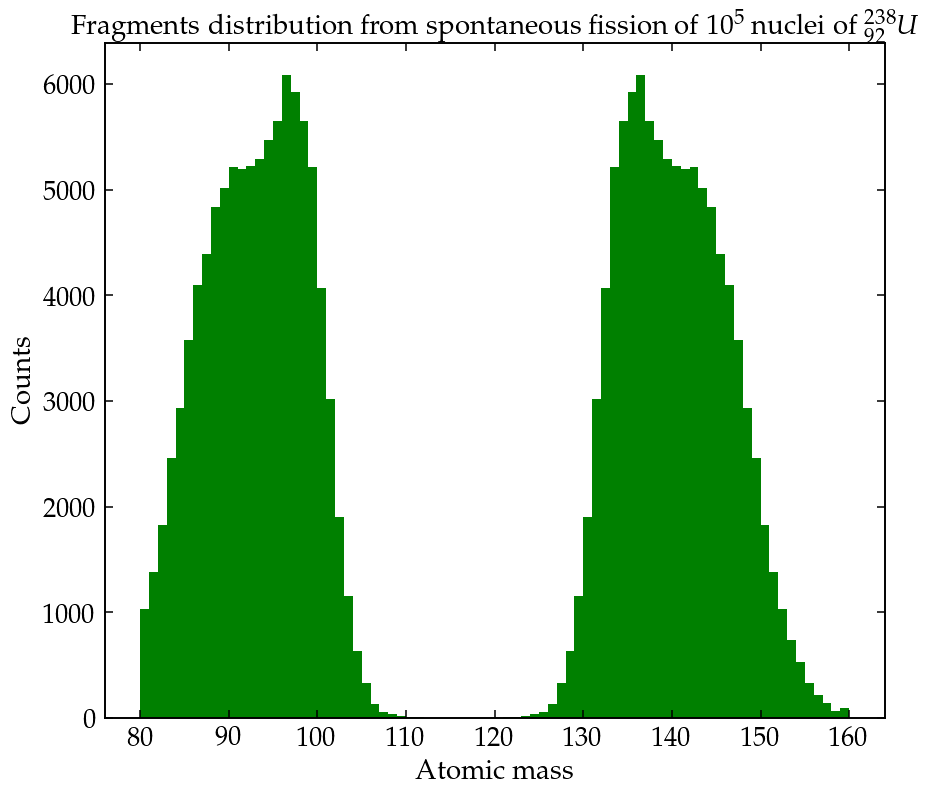

In [54]:
fig = plt.subplots(figsize =(12, 9))
plt.hist(A, 80, range = (80,160),color='g')

#plt.hist(Z, 29, range = (29,92-29),color='g')
#plt.hist(np.log10(E),80,log=True)
plt.title(r"Fragments distribution from spontaneous fission of $10^5$ nuclei of $^{238}_{92}U$", fontsize = 20)
plt.xlabel("Atomic mass", fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.savefig("FissionFragTh.jpg",bbox_inches="tight")
plt.show()

In [55]:
track = []
#strag = []

#print(N)

#mineral = 'Gypsum/'
#nuclei  = ' H- O-Ca- S'

#mineral = 'Halite/'
#nuclei = 'Na-Cl.txt'

mineral = 'Obsidian/'
nuclei = 'Si-Al-Fe-Ca-Na- K- O.txt'

mineral = 'Zircon/'
nuclei = 'Zr-Si- O.txt'

#mineral = 'Cerussite/'
#nuclei = ' O-Pb- C.txt'

#mineral = 'Pyromorphite/'
#nuclei = 'Pb- P- O-Cl.txt'

appo = 0

for i in range(N):
    
    if(i%10000 == 0):
        print(i)
    
    #e takes the energy of the fragment, x and y take the range obtained in the material
    
    e,x,y  = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = (0,4,8), unpack='true')
    unit_e = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 1, dtype = str, unpack='true')
    unit_x = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 5, dtype = str, unpack='true')
    #unit_y = np.loadtxt(mineral + str(int(Z[i])) + " in " + nuclei, usecols = 9, dtype = str, unpack='true')
    
    n = len(unit_e)
    
    for j in range(n):    
        if(unit_x[j] == "um"):
            x[j] *= 1e3
        else:
            x[j] *= 0.1
       
        '''if(unit_y[i] == "um"):
            y[i] *= 1e3
        else:
            y[i] *= 0.1'''
            
        if(unit_e[j] == "eV"):
            e[j] *= 1e-3
        elif(unit_e[j] == "MeV"):
            e[j] *= 1e3
            
    Etox = InterpolatedUnivariateSpline(e,x,k = 1)
    #Etoy = InterpolatedUnivariateSpline(e,y,k = 1)
    
    if (i % 2 == 0):   
        appo = Etox(E[i]*1e3)
        #length by the lighter fragment
    else:
        appo += Etox(E[i]*1e3)        
        track.append(appo)
        #sum of the length by the 2 objects
        
    #track.append(Etox(E[i]*1e3))
    #strag.append(Etoy(E[i]*1e3))
    
#print(min(track))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [56]:
n_bins = 100
x_min = 3 #log scale in nm
x_max = 5 #log scale in nm

#I consder the range between 1 nm and 10^5 nm

In [57]:
lenght = np.logspace(x_min,x_max,n_bins) # nm
count_Th  = np.zeros(n_bins-1)

for i in range(int(N/2)):
    if(i%10000 == 0):
        print(i)
    for j in range(n_bins-1):
        if(track[i] >= lenght[j] and track[i] < lenght[j+1]):
            count_Th[j] += 1
            #counting the decays which gave a track with length between length[j] and length[j+1]

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [58]:
l = np.logspace(x_min,x_max,10000)
R_Th = np.zeros(10000)

for i in range(n_bins-1):
    for j in range(10000):
        if(l[j] < lenght[i+1] and l[j] >= lenght[i]):
            R_Th[j] = count_Th[i]

In [59]:
print(count_Th)
print(count_U)

[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 1.6000e+01 8.0100e+02
 3.6400e+03 3.1243e+04 3.8987e+04 2.5311e+04 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000

In [63]:
filename = 'Th232histo.dat'

f = open(filename, "w")
g = open('U238histo.dat', "w")
print("l1  l2  N", file=f)
for j in range(len(count_Th)):
    print(l[j], l[j+1], count_Th[j], sep = '  ', file = f)
    print(l[j], l[j+1], count_U[j], sep = '  ', file = g)

# Fission induced

In [61]:
from scipy.optimize import curve_fit

In [62]:
for i in range(len(nuclei)):
    dirname = '../Resconi.txt'
    e, flux = np.loadtxt(dirname, usecols = (0, 1), delimiter = ', ', unpack = 'true')
n = 20
E = np.zeros(n)
F = np.zeros(n)
for i in range(n):
    E[i] = e[i]*1e3 #MeV
    F[i] = flux[i]/((e[i]**3)*1e3) #cm^-2 sr^-1 s^-1 MeV^-1

TypeError: Text reading control character must be a single unicode character or None; but got: ', '

In [ ]:
def func(x, a, b, c, d, e):
    return a + b * x + c * x**2 + d * x**3 + e * x**4

In [ ]:
popt, pcov = curve_fit(func, E, F)
#funct = log_interp1d(e, flux)

In [ ]:
plt.loglog(E, func(E, *popt))
plt.loglog(E, F)
#plt.loglog(e, funct(e), label='Esperimenti', linewidth=2)

In [ ]:
En = np.linspace(10, 100, 9)
for i in range(9):
    print(En[i], func(En[i], *popt))
plt.loglog(En, func(En, *popt))

In [ ]:
Ezr = 100
f = lambda x : func(x, *popt)
Number = quad(f, 0, Ezr)[0]*np.pi*100*3600*24*365*1e6
print(Number)

In [ ]:
mass = 10**3*rho_Zirc*1e-3
Na  = 6.022e23

tau_U = 6.45e3 #Myr 
tau_Th = 1.405e4/np.log(2)
BR_U = 5.4e-7
BR_Th = 1.1e-11
fraction_U = 0.003
fraction_Th = 0.007
factor_U = 1e-5*(BR_U)*((fraction_U)*Na*1e3/(238))/tau_U
factor_Uind = 1e-5*(0.14*Number)*(fraction_U)/mass*(np.exp(-1/tau_U))
factor_Th = 1e-5*(BR_Th)*((fraction_Th)*Na*1e3/(232))/tau_Th
factor_Thind = 1e-5*(0.02*Number)*(fraction_Th)/mass*(np.exp(-1/tau_Th))
#1e-5 perchè conto il numero di tracce per fissione, 0.14*Number il numero di fissioni se fosse tutto U, 1e-10 perchè è la frazione di U

lenght_width = np.diff(lenght)
lenght_mid   = lenght[:-1] + lenght_width/2

plt.figure(figsize=(12,8))
#plt.loglog(l,R*factor, label='SFF')
plt.loglog(lenght_mid,count_U*factor_U/lenght_width, label='SSF Uranium')
plt.loglog(lenght_mid,count_Th*factor_Th/lenght_width, label='SSF Thorium')
plt.loglog(lenght_mid,count_U*factor_Uind/lenght_width, label='MIF Uranium')
plt.loglog(lenght_mid,count_Th*factor_Thind/lenght_width, label='MIF Thorium')
ax = plt.gca()
plt.title(r"Spontaneous and muon induced fission of $^{238}_{92}U$ in obsidian")
#plt.ylabel("dR/dE [recoils/Myr/keV/cmq]")
plt.ylabel("dR/dx [$Myr^{-1} \ nm{^-1} \ kg{^-1}$]")
plt.xlabel("x [nm]")
plt.grid()
plt.legend()
plt.xlim(0.1,1e5)
#plt.savefig("MuonFission.pdf",bbox_inches="tight")
plt.show()



In [ ]:
mass = 10**3*rho_Zirc*1e-3
Na  = 6.022e23

tau_U = 6.45e3 #Myr 
tau_Th = 1.405e4/np.log(2)
BR_U = 5.4e-7
BR_Th = 1.1e-11

TotU = 0
TotTh = 0

for i in range(len(count_U)):
    TotU += count_U[i]
    TotTh += count_Th[i]

f1U = 0.003
f1Th = 0.00
f2U = 0.003
f2Th = 0.059
CU = 1e-5*(BR_U)*(Na*1e3/(238))/tau_U*mass #[Myr^-1]
CUind = 1e-5*(0.14*Number) #[Myr^-1]
CTh = 1e-5*(BR_Th)*(Na*1e3/(232))/tau_Th*mass #[Myr^-1]
CThind = 1e-5*(0.02*Number) #[Myr^-1]

N1 = f1U*(CU+CUind)+f1Th*CThind
N2 = f2U*(CU+CUind)+f2Th*CThind

N1no = f1U*CU
N2no = f2U*CU

print(N2/N1, N2no/N1no)


In [ ]:
def ind(f):
    N1 = f1U*(CU+CUind)
    N2 = f2U*(CU+CUind)+f*CThind
    return N2/N1


In [ ]:
f2Th = np.linspace(0,0.08,100)


plt.figure(figsize=(12,8))
#plt.loglog(l,R*factor, label='SFF')
plt.plot(f2Th,ind(f2Th), label='Induced')
plt.axhline(y=f2U/f1U, xmin=0.05, xmax=0.95, color = 'red', label='No induced')
#plt.title(r"Spontaneous and muon induced fission of $^{238}_{92}U$ in obsidian")
#plt.ylabel("dR/dE [recoils/Myr/keV/cmq]")
#plt.ylabel("dR/dx [$Myr^{-1} \ nm{^-1} \ kg{^-1}$]")
#plt.xlabel("x [nm]")
plt.legend()
#plt.savefig("MuonFission.pdf",bbox_inches="tight")
plt.show()




# Time plot

In [ ]:
time = 1

def sigma(f, time):
    N1 = f1U*(CU+CUind)*time
    N2 = f2U*(CU+CUind)*time+f*CThind*time
    return N2/N1*np.sqrt(1/N2+1/N1)

def sigmanoin(N1, N2):
    return N2/N1*np.sqrt(1/N2+1/N1)

In [ ]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }


fig, axe = plt.subplots(figsize=(12, 8), dpi=800)

c = []
for i in range(100):
    c.append(1)
    
axe.plot(f2Th,ind(f2Th), label='Induced', color = 'blue', linestyle = '-.')
axe.fill_between(f2Th,ind(f2Th)-sigma(f2Th,time),ind(f2Th)+sigma(f2Th,time), color = 'blue', alpha = 0.25)
axe.plot(f2Th, c, label='No Induced', color = 'red', linestyle = '-.')
axe.fill_between(f2Th, c-sigmanoin(f1U*CU*time,f2U*CU*time),c+sigmanoin(f1U*CU*time,f2U*CU*time), color = 'red', alpha = 0.25)

#plt.title(r"Spontaneous and muon induced fission of $^{238}_{92}U$ in obsidian")
plt.ylabel("$\\rho$")
plt.xlabel("$f_2^{Th}$")
plt.legend()

txt = r"Time period = 1 $Myr$"
axe.text(0.015, 1.004, txt, fontdict = font)
#plt.savefig("MuonFission.pdf",bbox_inches="tight")
plt.show()

In [50]:
def pltgraph(time, number):
    font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }


    fig, axe = plt.subplots(figsize=(12, 8), dpi=800)

    c = []
    for i in range(100):
        c.append(1)
    
    axe.plot(f2Th,ind(f2Th), label='Induced', color = 'blue', linestyle = '-.')
    axe.fill_between(f2Th,ind(f2Th)-sigma(f2Th,time),ind(f2Th)+sigma(f2Th,time), color = 'blue', alpha = 0.25)
    axe.plot(f2Th, c, label='No Induced', color = 'red', linestyle = '-.')
    axe.fill_between(f2Th, c-sigmanoin(f1U*CU*time,f2U*CU*time),c+sigmanoin(f1U*CU*time,f2U*CU*time), color = 'red', alpha = 0.25)

    #plt.title(r"Spontaneous and muon induced fission of $^{238}_{92}U$ in obsidian")
    plt.ylabel("$\\rho$")
    plt.xlabel("$f_2^{Th}$")
    plt.ylim(0.998, 1.005)
    plt.legend(loc='upper left')

    txt = r"Time period = "+str(time)+" $Myr$"
    axe.text(0.015, 1.0036, txt, fontdict = font)
    if (number<10):
        plt.savefig('./Figuretime/rhovsf00'+str(number)+'.png')
    elif (number<100 and number >= 10):
        plt.savefig('./Figuretime/rhovsf0'+str(number)+'.png')
    else: plt.savefig('./Figuretime/rhovsf'+str(number)+'.png')
    plt.close(fig)

In [51]:
timeperiod = np.linspace(0.01,1,100)
print(timeperiod)
for i in range(100):
    pltgraph(timeperiod[i], i)
    print(i)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.  ]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
import os
import imageio

j = 0
png_dir = './Figuretime'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        print(j)
        j = j+1
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

0


/var/folders/rs/y31t400d08x63f54tfx6sjy00000gp/T/ipykernel_21241/1130566.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0


/var/folders/rs/y31t400d08x63f54tfx6sjy00000gp/T/ipykernel_21241/1130566.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [ ]:
# Make it pause at the end so that the viewers can ponder
for i in range(100):
    print(i)
    images.append(imageio.imread(file_path))

imageio.mimsave('./Figuretime.gif', images)

# Surface plot

In [1]:
time = 1 #Myr

def sigma(f, surface):
    N1 = f1U*(CU+CUind)*time/mass*rho_Zirc*1e-3*10*surface
    N2 = (f2U*(CU+CUind)*time+f*CThind*time)/mass*rho_Zirc*1e-3*10*surface
    return N2/N1*np.sqrt(1/N2+1/N1)

def sigmanoin(N1, N2):
    return N2/N1*np.sqrt(1/N2+1/N1)

In [2]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }


fig, axe = plt.subplots(figsize=(12, 8), dpi=800)

surface = 100
c = []
for i in range(100):
    c.append(1)
    
#axe.plot(f2Th,ind(f2Th), label='Induced', color = 'blue', linestyle = '-.')
axe.plot(f2Th,ind(f2Th), label='Induced', color = 'blue', linestyle = '-.')
axe.fill_between(f2Th,ind(f2Th)-sigma(f2Th,surface),ind(f2Th)+sigma(f2Th,surface), color = 'blue', alpha = 0.25)
axe.plot(f2Th, c, label='No Induced', color = 'red', linestyle = '-.')
axe.fill_between(f2Th, c-sigmanoin(f1U*CU*time/mass*rho_Zirc*1e-3*10*surface,f2U*CU*time/mass*rho_Zirc*1e-3*10*surface),c+sigmanoin(f1U*CU*time,f2U*CU*time), color = 'red', alpha = 0.25)

plt.ylabel("$\\rho$")
plt.xlabel("$f_2^{Th}$")
plt.legend()
txt = r"Surface area = 100 $cm^2$"
axe.text(0.015, 1.004, txt, fontdict = font)
plt.show()

NameError: name 'plt' is not defined

In [3]:
def pltgraph(surface, number):
    font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }


    fig, axe = plt.subplots(figsize=(12, 8), dpi=800)

    c = []
    for i in range(100):
        c.append(1)
    
    axe.plot(f2Th,ind(f2Th), label='Induced', color = 'blue', linestyle = '-.')
    axe.fill_between(f2Th,ind(f2Th)-sigma(f2Th,surface),ind(f2Th)+sigma(f2Th,surface), color = 'blue', alpha = 0.25)
    axe.plot(f2Th, c, label='No Induced', color = 'red', linestyle = '-.')
    axe.fill_between(f2Th, c-sigmanoin(f1U*CU*time/mass*rho_Zirc*1e-3*10*surface,f2U*CU*time/mass*rho_Zirc*1e-3*10*surface),c+sigmanoin(f1U*CU*time,f2U*CU*time), color = 'red', alpha = 0.25)

    #plt.title(r"Spontaneous and muon induced fission of $^{238}_{92}U$ in obsidian")
    plt.ylabel("$\\rho$")
    plt.xlabel("$f_2^{Th}$")
    plt.legend()

    txt = r"Surface area = "+str(time)+" $cm^2$"
    axe.text(0.015, 1.004, txt, fontdict = font)
    if (number<10):
        plt.savefig('./Figurearea/rhovsf00'+str(number)+'.png')
    elif (number<100 and number >= 10):
        plt.savefig('./Figurearea/rhovsf0'+str(number)+'.png')
    else: plt.savefig('./Figurearea/rhovsf'+str(number)+'.png')
    plt.close(fig)

In [ ]:
area = np.linspace(10,1000,100)
for i in range(100):
    pltgraph(area[i], i)
    print(i)

In [ ]:
png_dir = './Figurearea'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(100):
    images.append(imageio.imread(file_path))

imageio.mimsave('./Figurearea.gif', images)